In [1]:
pip install phik shap optuna catboost lightgbm optuna-integration[sklearn] xlrd openpyxl -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import phik
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots

# Подготовка данных
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer

# Модели
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

## Бустинги
import catboost, lightgbm
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Перебор гиперпараметров
import optuna
from optuna import distributions
from optuna.integration import OptunaSearchCV

# Метрики
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay, roc_curve, auc, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay, classification_report

# Модули для работы с моделями, переборы гиперпараметров:
import optuna
from optuna import distributions
from optuna.integration import OptunaSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Кодировщики, масштабировние
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler


# модули для работы с моделями:
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline

# Кодировщики, масштабировние
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder

# Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# CatBoost и LGBM
import catboost, lightgbm
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Метрики
from sklearn.metrics import mean_squared_error, root_mean_squared_error, make_scorer, mean_absolute_error

In [3]:
# 1. Гистограмма и ящик с усами для числовых признаков
def graph(df, bins, x_name, title_name):
    f, ax = plt.subplots(1, 2)
    f.set_size_inches(20, 5)
    plt.suptitle(f'{title_name}', fontweight='bold')
    # Гистограмма:
    sns.histplot(data=df, bins=bins, color='coral', edgecolor=None, ax=ax[0])
    ax[0].set_title('Гистограмма распределения')
    ax[0].grid()
    ax[0].set_xlabel(x_name)
    ax[0].set_ylabel('частота')
    # Ящик с усами:
    ## vert=False, чтобы значения признака были по горизонтальной оси для обоих графиков
    sns.boxplot(data=df, orient='h', color='gray')
    ax[1].set_title('Ящик с усами')
    ax[1].grid()
    ax[1].set_xlabel(x_name)
    plt.show()
    
    display(pd.DataFrame(df.describe()).T)

# Для анализа остатков:
def make_hist(df, column, bins, p, x_name, title):
    f, ax = plt.subplots(1, 2)
    f.set_size_inches(20, 5)
    plt.suptitle(f'{p}', fontweight='bold')
    # Гистограмма:
    sns.histplot(data=df, x=column, bins=bins, color='coral', edgecolor=None, ax=ax[0])
    ax[0].set_title(f'{title}')
    ax[0].grid()
    ax[0].set_xlabel(x_name)
    ax[0].set_ylabel('частота')
    # Ящик с усами:
    ## vert=False, чтобы значения признака были по горизонтальной оси для обоих графиков
    sns.boxplot(data=df, x=column, orient='h', color='cornflowerblue')
    ax[1].set_title(f'Ящик с усами')
    ax[1].grid()
    ax[1].set_xlabel(x_name)
    plt.show()
    
# Для сравнения предсказанных и реальных тестовых значений
def build_joint_hist(y_test, y_pred, df_num, title):
    y_joint = pd.DataFrame(list(zip(y_test, preds)), columns=['y_test', 'preds'])
    make_hist(y_joint, None, 50, df_num, 'звонков', title)
    display(y_joint.describe().T)

In [4]:
RANDOM_STATE = 30

# Загрузка данных

In [5]:
df = pd.read_excel("data_for_test.xlsx")
display(df.head())
df.info()

,Date,Y,TV,OOH,Seasonal_Sales,Usd_rate
0,2013-01-01,NaN,0,0.0,0.060802,30.502001
1,2013-01-02,0.0,0,0.0,0.060802,30.337200
2,2013-01-03,17.0,0,0.0,0.060802,30.156500
3,2013-01-04,17.0,0,0.0,0.060802,30.271000
4,2013-01-05,8.0,0,0.0,0.060802,30.271000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762 entries, 0 to 761
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            762 non-null    datetime64[ns]
 1   Y               759 non-null    float64       
 2   TV              762 non-null    int64         
 3   OOH             762 non-null    float64       
 4   Seasonal_Sales  762 non-null    float64       
 5   Usd_rate        762 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 35.8 KB


## Вывод о датасете

6 столбцов, 762 строки
- Пропуски есть только в признаке `Y`, всего 3

Типы данных:
- `Date` - datetime
- `TV` - int
- Остальные - float

Целевая переменная:
- `Y` - количество звонков

**Что можно сделать**:
- Сделать из `Data` индекс
- Преобразовать тип данных в `Y` из float в int,    
т.к. по описанию данных это количество звонков - значение всегда должно быть целочисленным.

## Пропуски:

In [6]:
df.isna().sum()

Date              0
Y                 3
TV                0
OOH               0
Seasonal_Sales    0
Usd_rate          0
dtype: int64

- есть 3 пропуска в целевой переменной. Обычное удаление пропусков можешь повлечь разрушение монотонности данных. Дальше посмотрим, можно ли их чем-то заменить.

## Определение типа задачи:
- задача временных рядов.

# Анализ данных

## Date

Количество уникальных значений признака "дата":

In [7]:
df['Date'].nunique()

762

- Совпадает с количеством строк датасета. Значит, повторяющихся данных нет

Проверка на монотонность:

In [8]:
df['Date'].is_monotonic

True

- данные последовательны и не повторяются.

Перевод в индекс:

In [9]:
df.set_index('Date', inplace=True)

Отрезок, на котором распределены данные:

In [10]:
print ('Первая дата:', df.index.min())
print ('Последняя дата:', df.index.max())
print ('Временной отрезок:', df.index.max() - df.index.min())

Первая дата: 2013-01-01 00:00:00
Последняя дата: 2015-02-01 00:00:00
Временной отрезок: 761 days 00:00:00


- даты идут подряд от 01.01.2013 до 01.02.2015 без перерыва.

### Вывод:

Даты последовательны и не повторяются. Первая и последняя дата соответствуют заявленным в описании.
Даты идут подряд от 01.01.2013 до 01.02.2015 без перерыва.

## Создание новых столбцов

Создадим столбцы гол, месяц и день недели:

In [11]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day_of_week'] = df.index.dayofweek

## TV - показатель медиаактивности на ТВ

Распределение в общем виде:

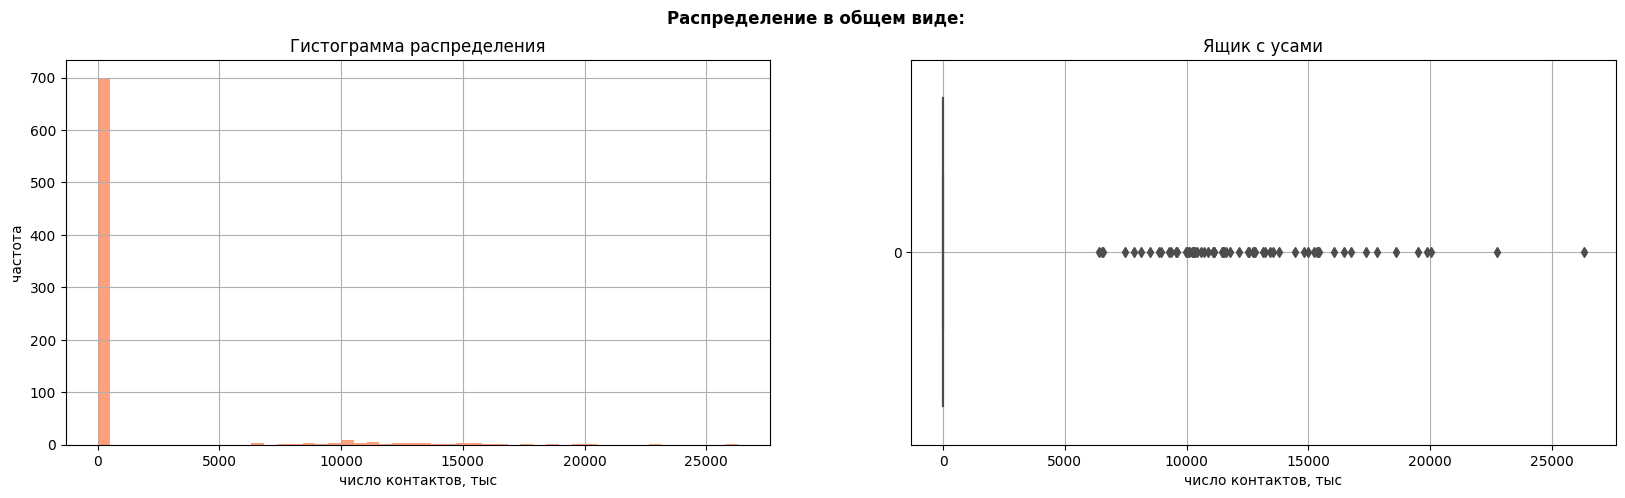

,count,mean,std,min,25%,50%,75%,max
TV,762.0,1040.011811,3645.686335,0.0,0.0,0.0,0.0,26310.0


Процент дней, когда были контакты по TV, от общего числа дней в датасете: 
 8.27 %


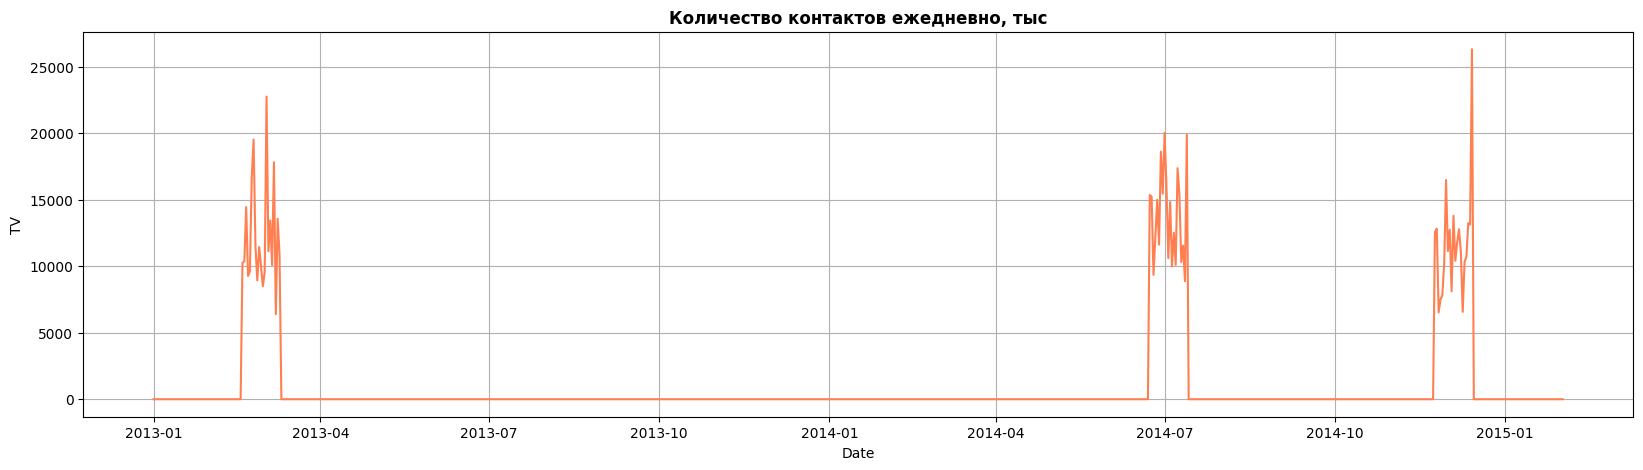

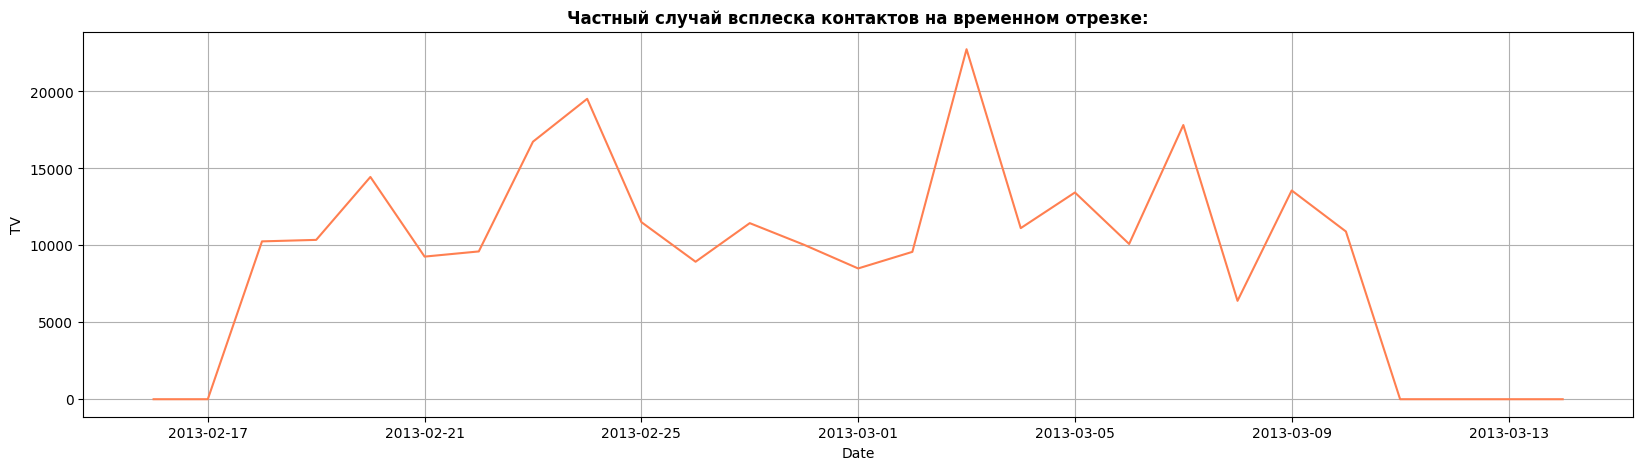

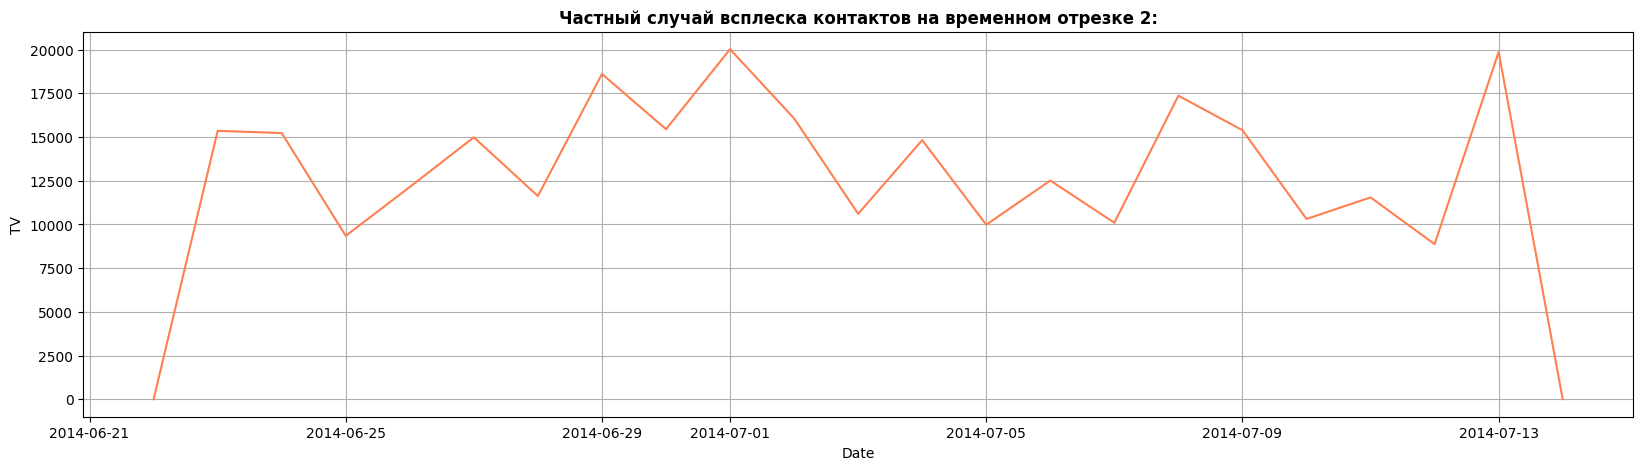

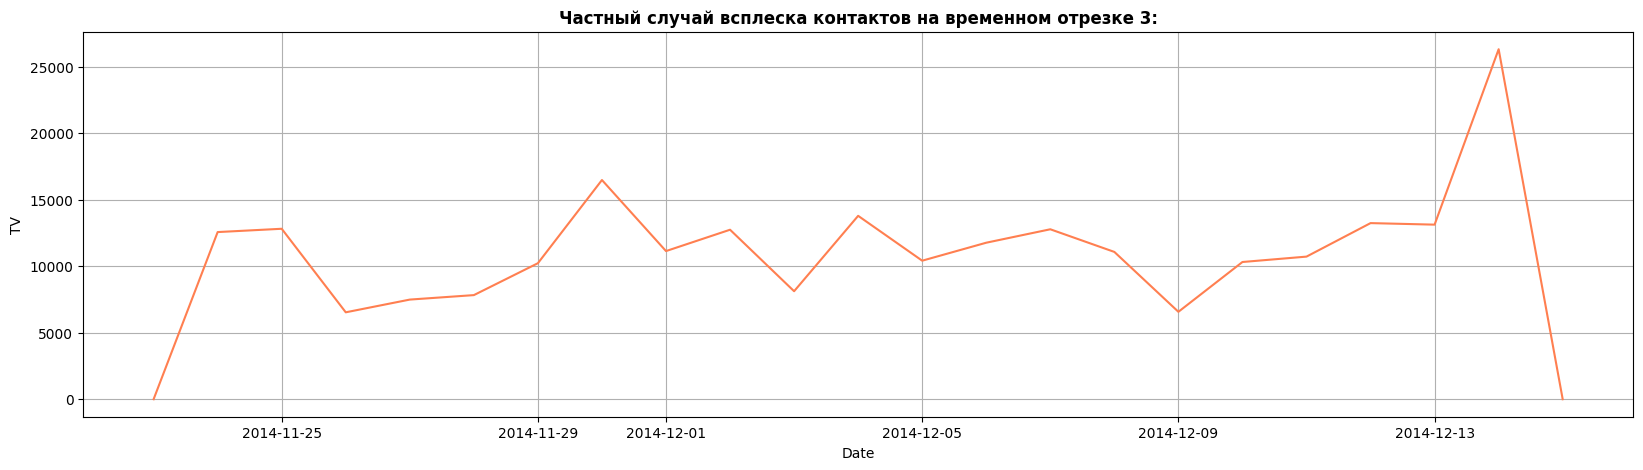

In [12]:
graph(df['TV'], 50, 'число контактов, тыс', 'Распределение в общем виде:')
print ('Процент дней, когда были контакты по TV, от общего числа дней в датасете: \n', round(len(df.query('TV!=0'))/len(df)*100, 2), '%')

titles = ['Количество контактов ежедневно, тыс', 'Частный случай всплеска контактов на временном отрезке:',
         'Частный случай всплеска контактов на временном отрезке 2:', 'Частный случай всплеска контактов на временном отрезке 3:']
p=0
for i in [df, df.loc[(df.index>'2013-02-15')&(df.index<'2013-03-15')],
         df.loc[(df.index>'2014-06-21')&(df.index<'2014-07-15')], df.loc[(df.index>'2014-11-22')&(df.index<'2014-12-16')]]:
    f, ax = plt.subplots(1, 1)
    f.set_size_inches(20, 5)
    sns.lineplot(data = i, x=i.index, y='TV', color='coral')
    plt.title(f'{titles[p]}', fontweight='bold')
    plt.grid()
    plt.show()
    p+=1

### Вывод:

*(графики выше)*

- Всего в 8.27% датасета есть информация о ненулевой оценке числа контактов через ТВ, в остальном это значение равно нулю.
- Наблюдается 3 всплеска активности контактов, пришедших через ТВ:
   1) *2013: 17 февраля - 11 марта*, - от 5000 до 22000 тыс контактов
   2) *2014: 23 июня - 13 июля*, ------ от 10000 до 20000 тыс контактов
   3) *2014: 24 ноября - 14 декабря*, - от 7000 до 26000 тыс контактов

Наибольший разброс и наивысшее количество контактов в день видим в ноябре-декабре 2014.   
Пик - 14 декабря 2014.  
Наибольший минимум контактов в день - июнь-июль 2014.



## Изменение степени влияния рекламной активности на ТВ

In [13]:
# Считаем корреляции ТВ с целевым признаком в разных временных отрезках
TV_cor_1 = round(df.loc[:'2013-08', :].phik_matrix(interval_cols=['Y', 'TV', 'OOH', 'Seasonal_Sales', 'Usd_rate']).loc['Y', 'TV'], 3)
TV_cor_2 = round(
    df.loc['2014-05':'2014-09', :].phik_matrix(interval_cols=['Y', 'TV', 'OOH', 'Seasonal_Sales', 'Usd_rate']).loc['Y', 'TV'], 3)
TV_cor_3 = round(
    df.loc['2014-10':, :].phik_matrix(interval_cols=['Y', 'TV', 'OOH', 'Seasonal_Sales', 'Usd_rate']).loc['Y', 'TV'], 3)


print ('Корреляция TV и Y: \n\nянварь-август 2013: ', TV_cor_1)
print ('май-сентябрь 2014: ', TV_cor_2)
print ('октябрь 2014 - февраль 2015: ', TV_cor_3)


C:\anaconda3\envs\practicum\lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable year for analysis 1. Dropping this column
  warnings.warn(
C:\anaconda3\envs\practicum\lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable year for analysis 1. Dropping this column
  warnings.warn(


Корреляция TV и Y: 

январь-август 2013:  0.284
май-сентябрь 2014:  0.0
октябрь 2014 - февраль 2015:  0.52


C:\anaconda3\envs\practicum\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable OOH for analysis 1. Dropping this column
  warnings.warn(


- Корреляция наивысшая в конце 14 - начале 15 года.
- Январь-август 2013 - эффективность рекламы в два раза ниже.
- Наименьшее влияние на колчество звонков реклама оказывала в мае-сентябре 2014.

## OOH

**Распределения по дням**


In [14]:
df['OOH'].value_counts()

0.0         747
4018.5        3
3928.5        2
5952.0        1
145137.0      1
993.0         1
11149.5       1
8439.0        1
39075.0       1
783.0         1
57999.0       1
55543.5       1
12124.5       1
Name: OOH, dtype: int64

- значение вписывается только в один из дней месяца, в остальных стоит 0.

Для удобства в столбце `OOH` заполним каждую строку максимальным значением в столбце по месяцу - т.е. месячное число контактов будет отображаться в датасете не только 1 числа каждого месяца, но и во всех остальных днях соответствующего месяца:

In [15]:
for p in [2013, 2014]:
    for i in range(1, 10):
        df.loc[f'{p}-0{i}']['OOH'] = df.loc[f'{p}-0{i}']['OOH'].max().round(2)
    for i in range(10, 13):
        df.loc[f'{p}-{i}']['OOH'] = df.loc[f'{p}-{i}']['OOH'].max().round(2)
for i in range(1, 3):
    df.loc[f'2015-0{i}']['OOH'] = df.loc[f'2015-0{i}']['OOH'].max().round(2)

C:\Users\Денис\AppData\Local\Temp\ipykernel_16072\1788918307.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[f'{p}-0{i}']['OOH'] = df.loc[f'{p}-0{i}']['OOH'].max().round(2)
C:\Users\Денис\AppData\Local\Temp\ipykernel_16072\1788918307.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[f'{p}-{i}']['OOH'] = df.loc[f'{p}-{i}']['OOH'].max().round(2)
C:\Users\Денис\AppData\Local\Temp\ipykernel_16072\1788918307.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

Строим графики:

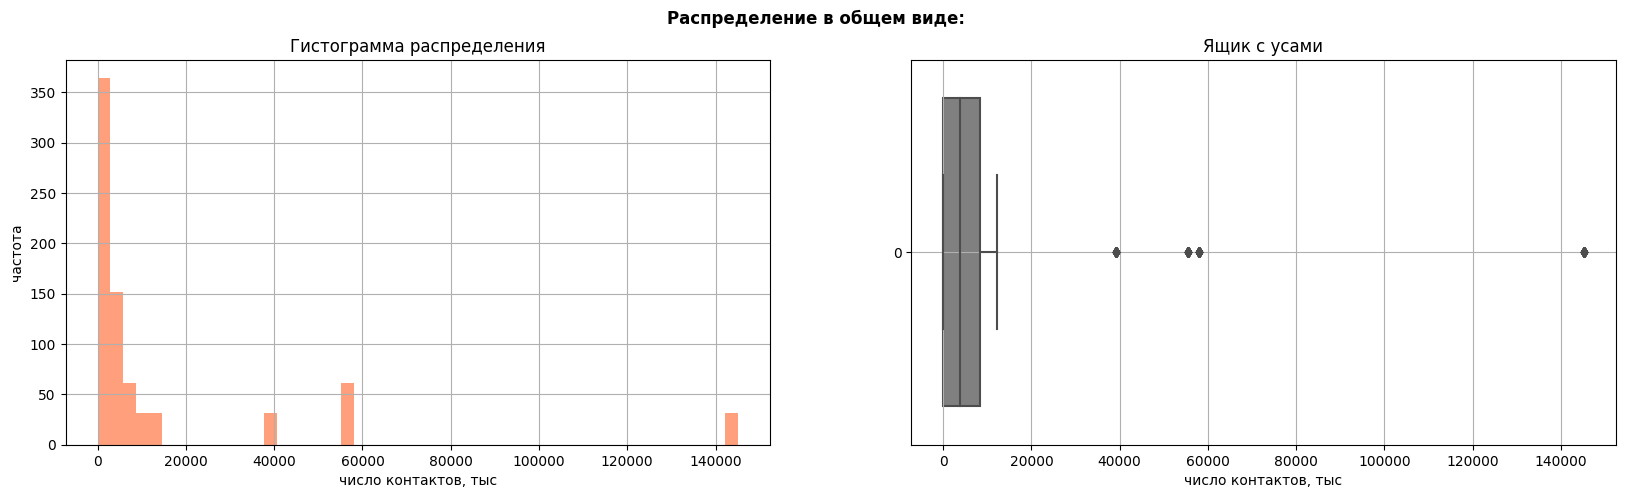

,count,mean,std,min,25%,50%,75%,max
OOH,762.0,14425.124016,31444.412198,0.0,0.0,3928.5,8439.0,145137.0


Процент дней, где месячные контакты по ООН выше нуля, от общего количества строк df: 
 60.37 %


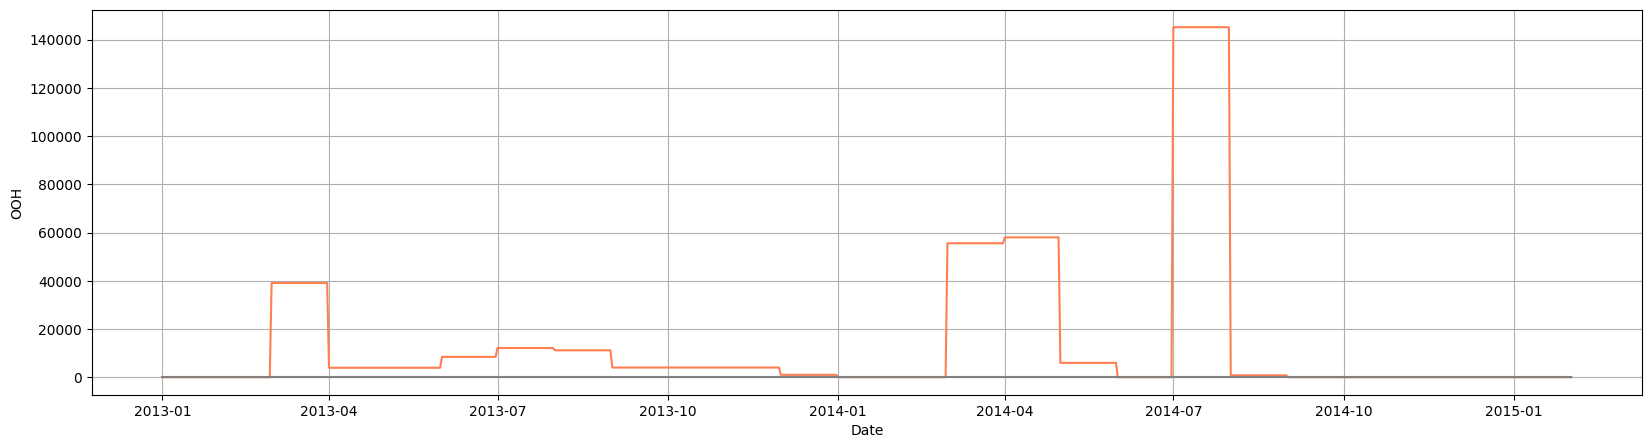

In [16]:
graph(df['OOH'], 50, 'число контактов, тыс', 'Распределение в общем виде:')
print ('Процент дней, где месячные контакты по ООН выше нуля, от общего количества строк df: \n', round(len(df.query('OOH!=0'))/len(df)*100, 2), '%')

f, ax = plt.subplots(1, 1)
f.set_size_inches(20, 5)
sns.lineplot(data = df, x=df.index, y='OOH', color='coral')
sns.lineplot(data = df.query('OOH==0'), x=df.query('OOH==0').index, y='OOH', color='grey')
plt.grid()
plt.show()

**Распределения по месяцам**

Создадим сводную таблицу по месячному числу контактов для дальнейшей визуализации:

In [17]:
helper = df.groupby(['year', 'month'])['OOH'].max()
helper = pd.DataFrame(helper)
helper.head()

OOH
year month         
2013 1          0.0
     2          0.0
     3      39075.0
     4       3928.5
     5       3928.5

In [18]:
helper = helper.reset_index()
for i in range(0, 26):
    if helper.loc[i, 'year']==2014:
        helper.loc[i, 'month'] += 12
    if helper.loc[i, 'year']==2015:
        helper.loc[i, 'month'] += 24

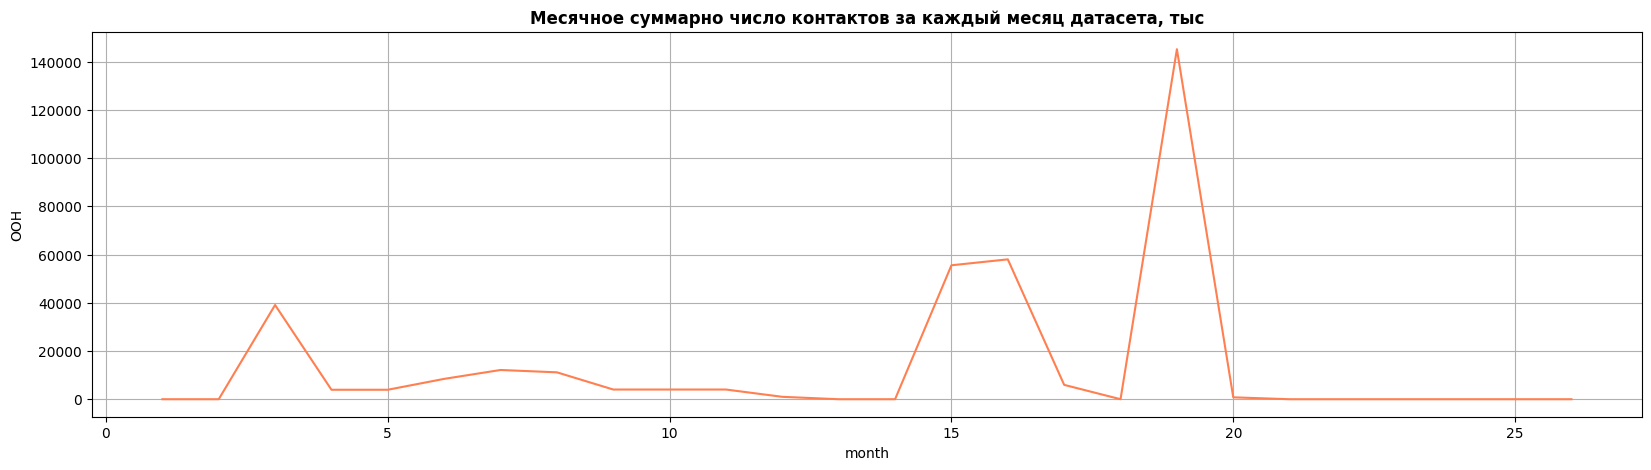

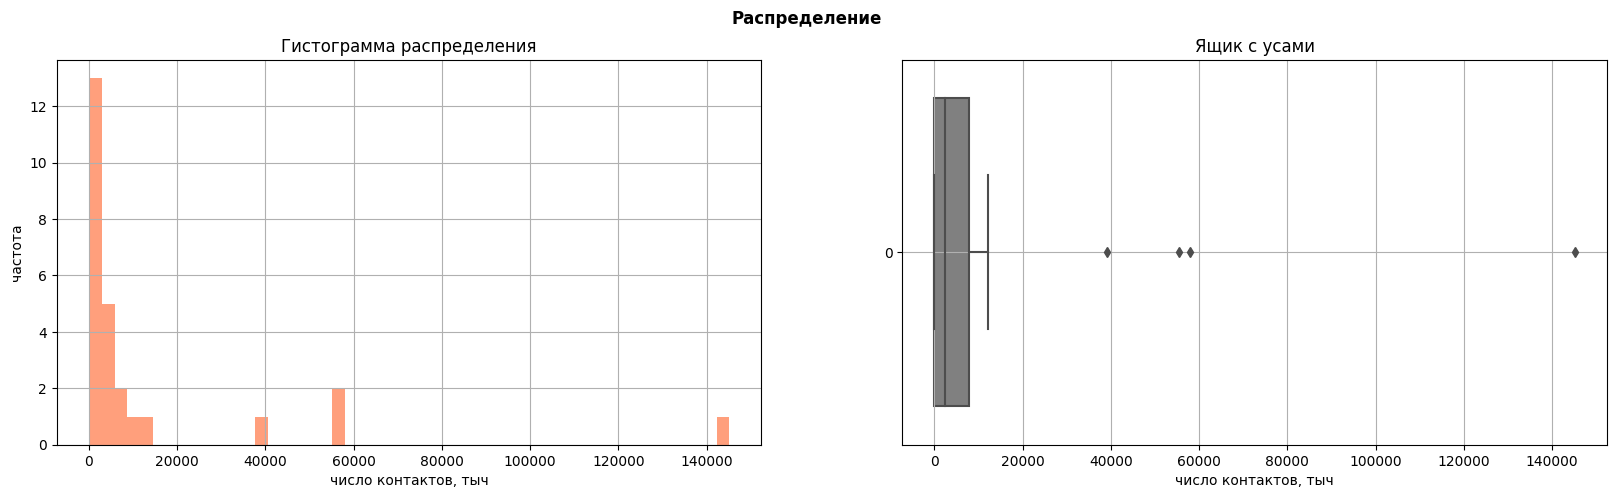

,count,mean,std,min,25%,50%,75%,max
OOH,26.0,13734.923077,31365.322343,0.0,0.0,2460.75,7817.25,145137.0


In [19]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(20, 5)
sns.lineplot(data = helper, x=helper['month'], y='OOH', color='coral')
plt.title('Месячное суммарно число контактов за каждый месяц датасета, тыс', fontweight='bold')
plt.grid()
plt.show()

graph(helper['OOH'], 50, 'число контактов, тыч', 'Распределение')

In [20]:
print ('Процент месяцев, в которых число контактов было равно нулю:\n', round(len(helper.loc[helper['OOH']==0])/len(helper)*100, 2))

Процент месяцев, в которых число контактов было равно нулю:
 42.31


### Вывод:

*(графики выше)*

Пики контактов:
- март 2013
- март, апрель 2014
- июль 2014

Самое большое значение:
- 145.137 млн контактов в месяц

Медианное значение: 
- 2460750 контактов в месяц

Среднее: 
- 13734923.077 контактов в месяц. Сильно завышается из-за пика в июле 2014

При этом в 42% месяцев в представленном датасете число контактов по наружной рекламе равно нулю.

## Seasonal_Sales

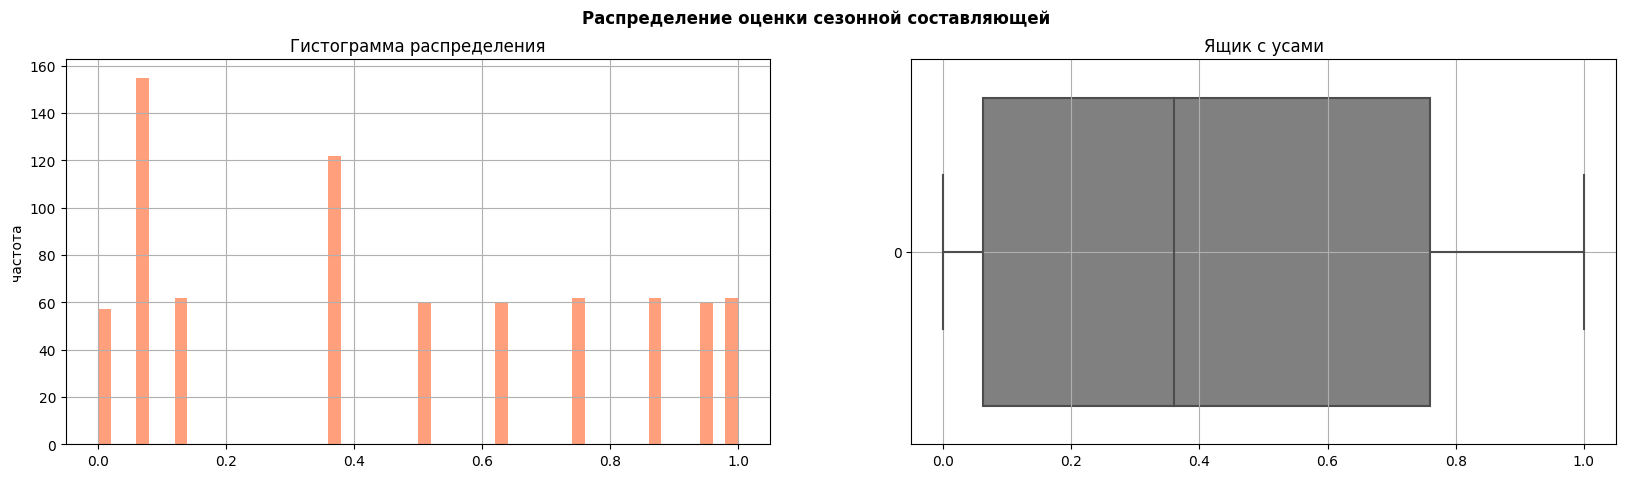

,count,mean,std,min,25%,50%,75%,max
Seasonal_Sales,762.0,0.460017,0.353072,0.0,0.062488,0.360924,0.7597,1.0


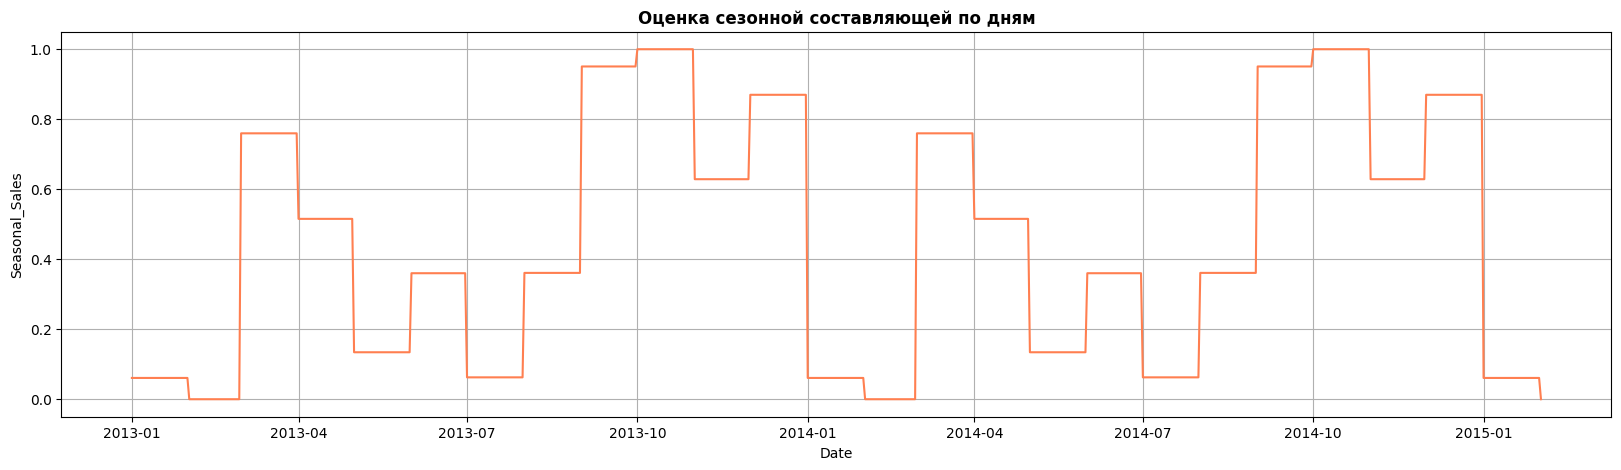

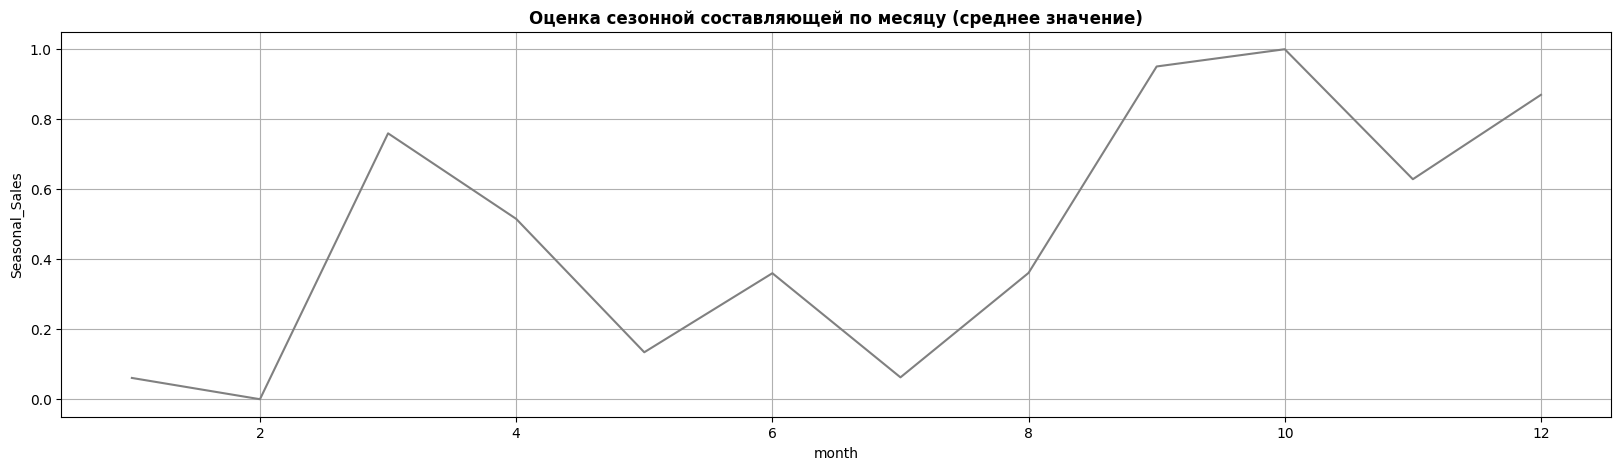

In [21]:
graph(df['Seasonal_Sales'], 50, '', 'Распределение оценки сезонной составляющей')

f, ax = plt.subplots(1, 1)
f.set_size_inches(20, 5)
sns.lineplot(data = df, x=df.index, y='Seasonal_Sales', color='coral')
plt.title('Оценка сезонной составляющей по дням', fontweight='bold')
plt.grid()
plt.show()

f, ax = plt.subplots(1, 1)
f.set_size_inches(20, 5)
sns.lineplot(data = df.groupby('month')['Seasonal_Sales'].mean(), x=df.groupby('month')['Seasonal_Sales'].mean().index, 
             y=df.groupby('month')['Seasonal_Sales'].mean(), color='grey')
plt.title('Оценка сезонной составляющей по месяцу (среднее значение)', fontweight='bold')
plt.grid()
plt.show()

### Вывод:

*(графики выше)*

По большей части нормированная оценка сезонной составляющей продаж автомобиля не превышает значения 0.5.    
В половине случаев она ниже 0.36.

Максимум:
- 1

Среднее и медианное:
- 0.46 и 0.36 соответственно

Видим наличие сезонности:
- низкие значения в январе-феврале
- скачок в марте
- снижение к июлю
- повышение до пикового значения в октябре
- спад в январе

Доля выше 0.5 в месяцах:
- март, апрель, сентябрь, октябрь, ноябрь, декабрь

## Usd_rate

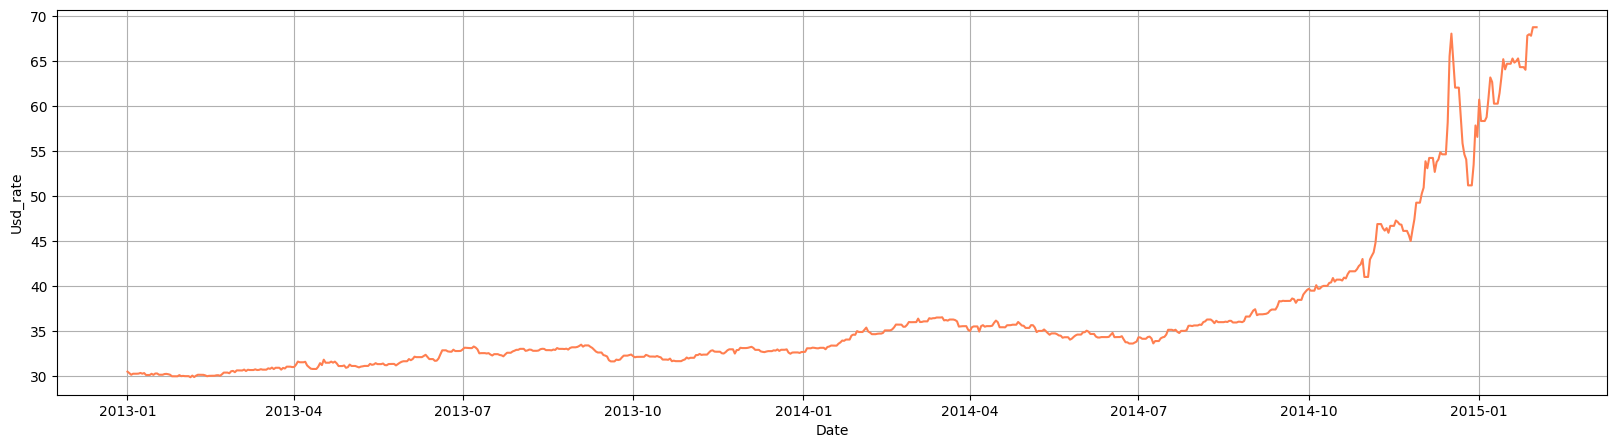

In [22]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(20, 5)
sns.lineplot(data = df, x=df.index, y='Usd_rate', color='coral')
plt.title('')
plt.grid()
plt.show()

### Вывод:

*(графики выше)*

- Курс доллара начал явный рост после июля 2014.

- К февралю 2015 вырос примерно в два раза.

## Y - целевая переменная

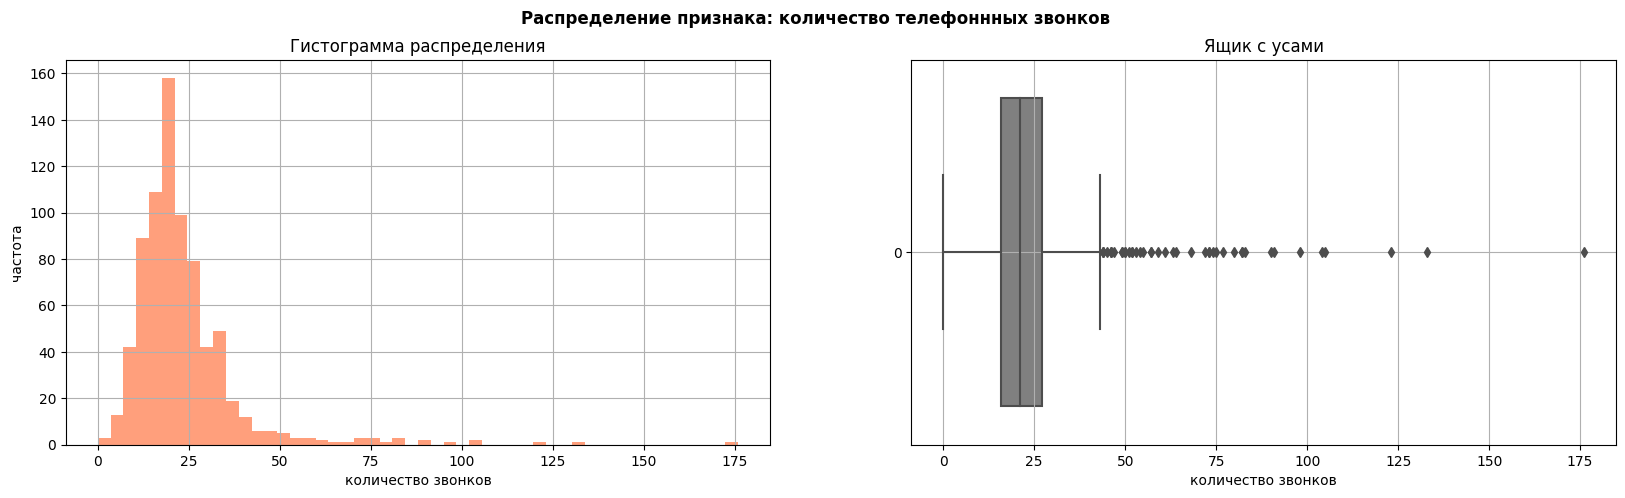

,count,mean,std,min,25%,50%,75%,max
Y,759.0,23.627141,15.08155,0.0,16.0,21.0,27.0,176.0


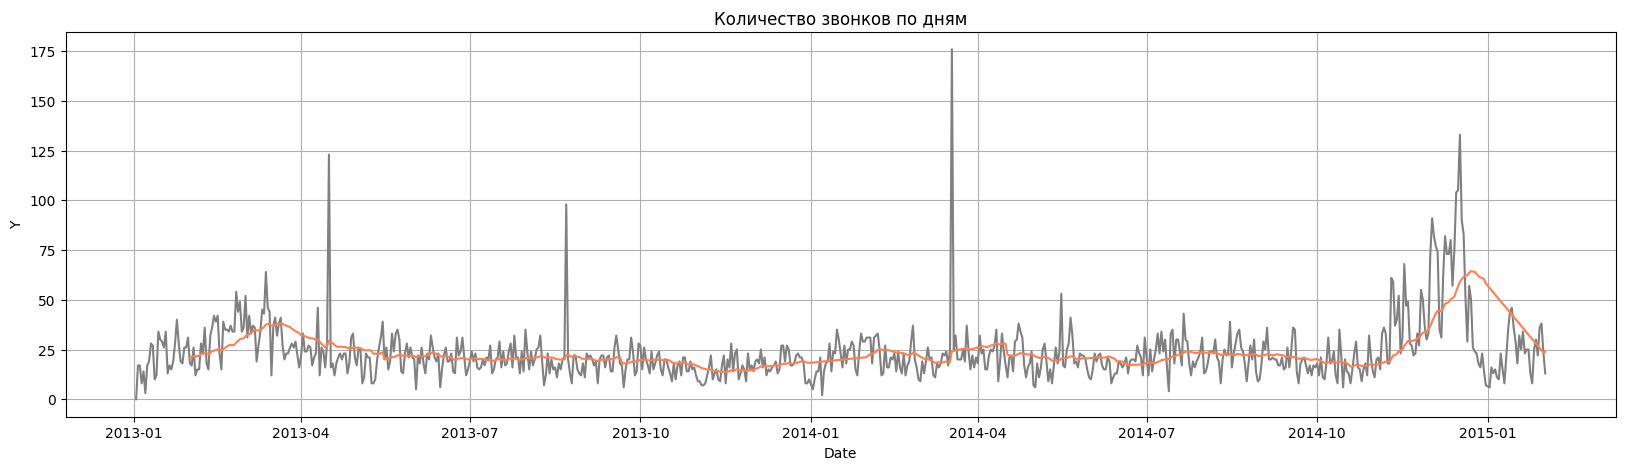

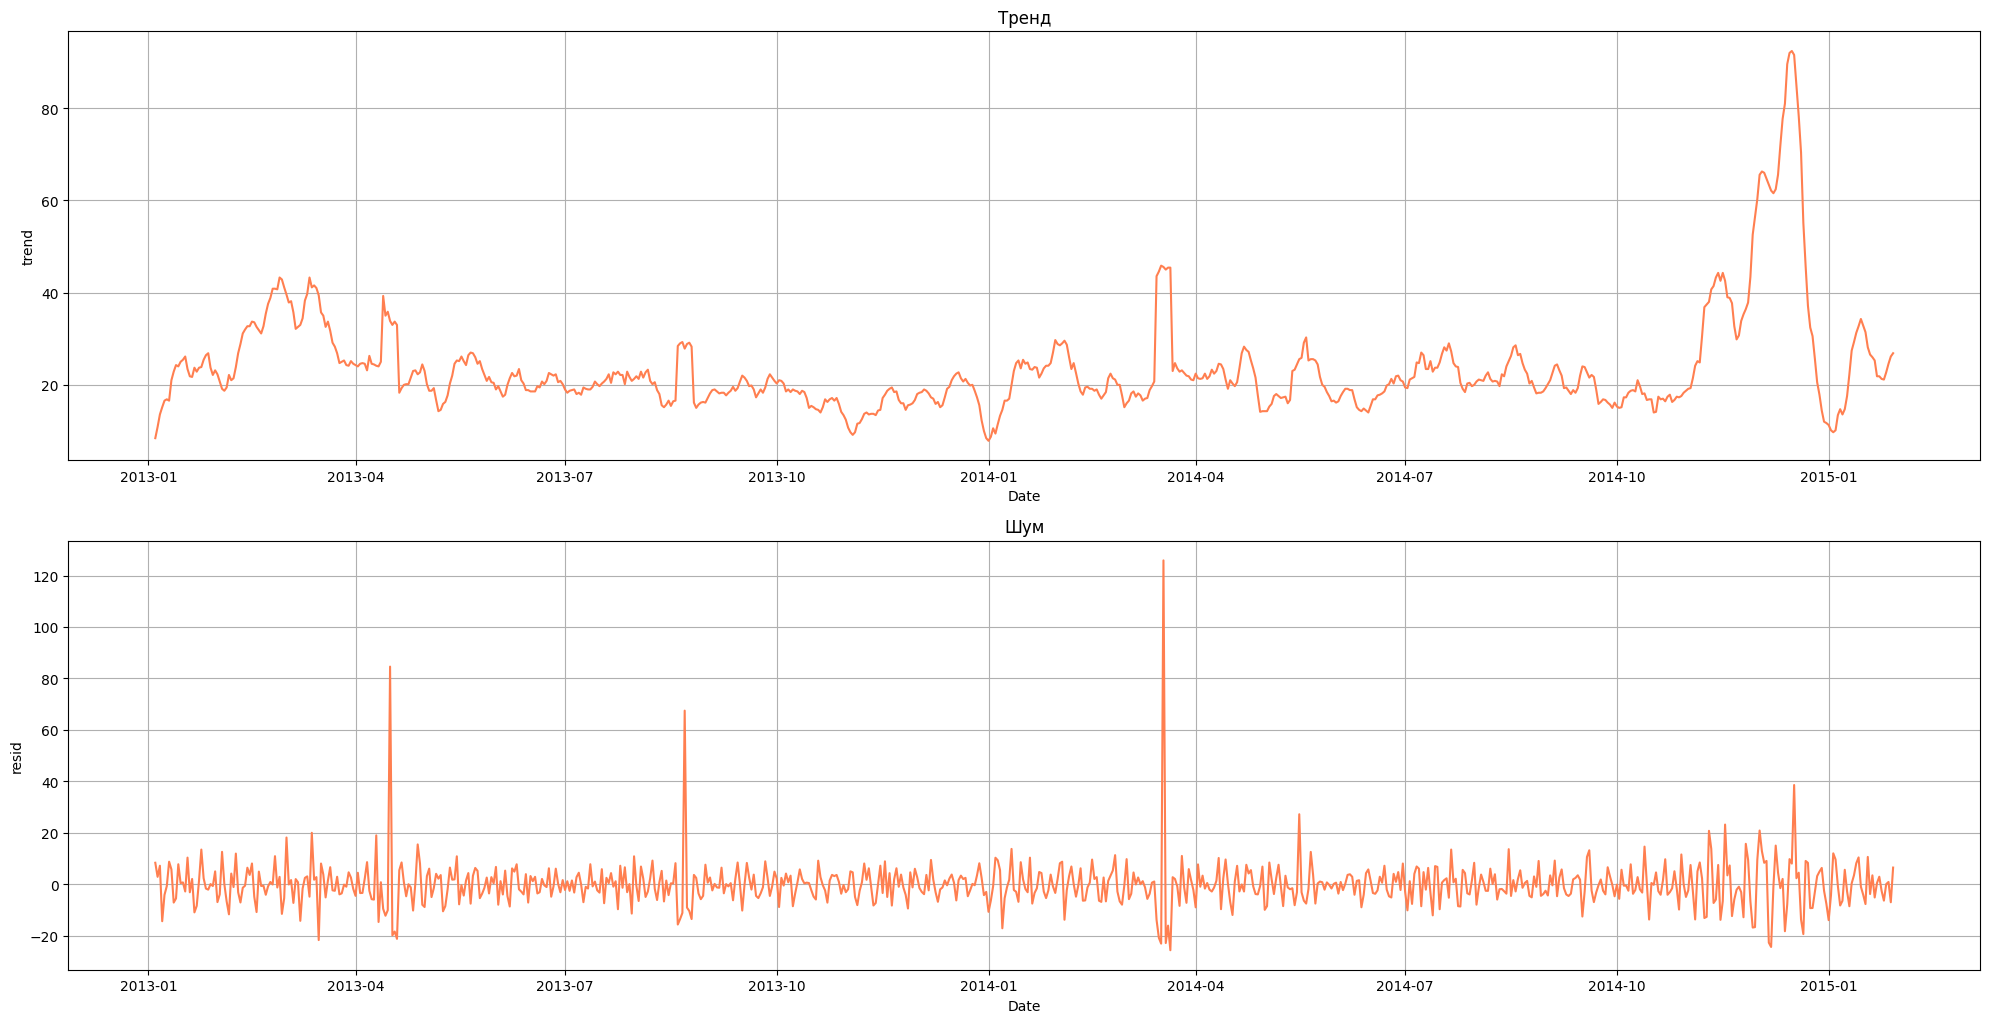

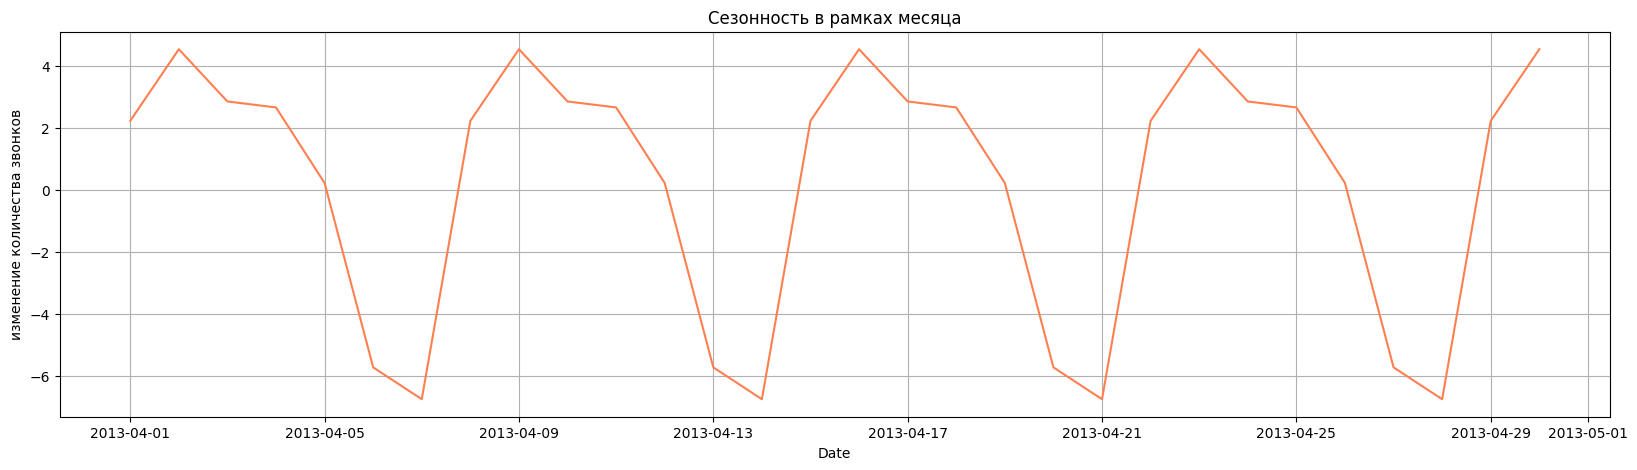

Порядковый номер дней недели на выбранном отрезке:
 [1, 2, 3, 4, 5, 6, 7, 1, 2, 3, 4, 5, 6, 7, 1, 2, 3, 4, 5, 6, 7, 1, 2, 3, 4, 5, 6, 7, 1, 2]


In [23]:
graph(df['Y'], 50, 'количество звонков', 'Распределение признака: количество телефоннных звонков')

f, ax = plt.subplots(1, 1)
f.set_size_inches(20, 5)
sns.lineplot(data = df, x=df.index, y='Y', color='gray')
sns.lineplot(data = df, x=df.index, y=df['Y'].rolling(30).mean(), color='coral')
plt.title('Количество звонков по дням')
plt.grid()
plt.show()

decomposed = seasonal_decompose(df.fillna(0)['Y'])
plt.figure(figsize=(20, 15))
titles = ['Тренд', 'Шум']
order = 311
p=0
for i in [decomposed.trend, decomposed.resid]:
    plt.subplot(order+p)
    sns.lineplot(data = i, color='coral', ax=plt.gca())
    plt.title(f'{titles[p]}')
    plt.grid()
    p+=1
plt.tight_layout()
plt.show()

f, ax = plt.subplots(1, 1)
f.set_size_inches(20, 5)
sns.lineplot(data = decomposed.seasonal['2013-04':'2013-04'], color='coral', ax=plt.gca())
plt.title('Сезонность в рамках месяца')
plt.ylabel('изменение количества звонков')
plt.grid()
plt.show()
print ('Порядковый номер дней недели на выбранном отрезке:\n', list(decomposed.seasonal['2013-04':'2013-04'].index.dayofweek+1))

_______

### Выводы:

*(графики выше)*

Распределение:
- от 0 до 176 в день
- в среднем - 23.6 в день
- в половине случаев - 16 до 27

На графике видим по крайней мере 3 явных выброса. Это может быть ошибка в данных (например, значения увеличены в 10 раз), но корректировать на всякий случай не будем: данные могут быть реальны и связаны с каким-то другим событием, не указанным в датасете.

__________
Среднее количество звонков:
- относительно высокое в марте-апреле 2013.  
- спад - с апреля 2013 по ноябрь 2013.
- явный быстрый рост - с ноября 2013 по январь 2014.
_____
Тренд:
- видим сильный рост к концу 2013 года. Однако, его нельзя назвать устойчивым. Вероятно, он связан с предновогодней рекламой, т.к. в январе резко пошел на спад.
_______
Шум:
- резкие скачки звонков в апреле и августе 2023, марте 2024. 
_____
Сезонность, месячная:
- С понедельника по четверг включительно - количество звонков наибольшее 
- Пятница - спад
- Выходные - низкое количествено звонков


### Заполнение пропусков

У нас всего один случай, когда количество звонков равно нулю - 2 января 2013 года.  
При этом все пропуски - 1 января.


In [24]:
print ('Пропуски\n', df.isna().sum())

print ('\nДаты, когда зафиксировано 0 звонков:\n', df.query('Y==0').index)
print ('Строки с пропусками:')
df[df.isna().any(axis=1)] 

Пропуски
 Y                 3
TV                0
OOH               0
Seasonal_Sales    0
Usd_rate          0
year              0
month             0
day_of_week       0
dtype: int64

Даты, когда зафиксировано 0 звонков:
 DatetimeIndex(['2013-01-02'], dtype='datetime64[ns]', name='Date', freq=None)
Строки с пропусками:


,Y,TV,OOH,Seasonal_Sales,Usd_rate,year,month,day_of_week
Date,,,,,,,,
2013-01-01,NaN,0,0.0,0.060802,30.502001,2013,1,1
2014-01-01,NaN,0,0.0,0.060802,32.683201,2014,1,2
2015-01-01,NaN,0,0.0,0.060802,60.700001,2015,1,3


**Решение:**
- заменим пропуски на 0. Скорее всего, в этот день их просто не было, либо компания не работала в этот день и не принимала звонки.

In [25]:
df = df.fillna(0)

In [26]:
df['Y'] = df['Y'].astype('int')

## Зависимости


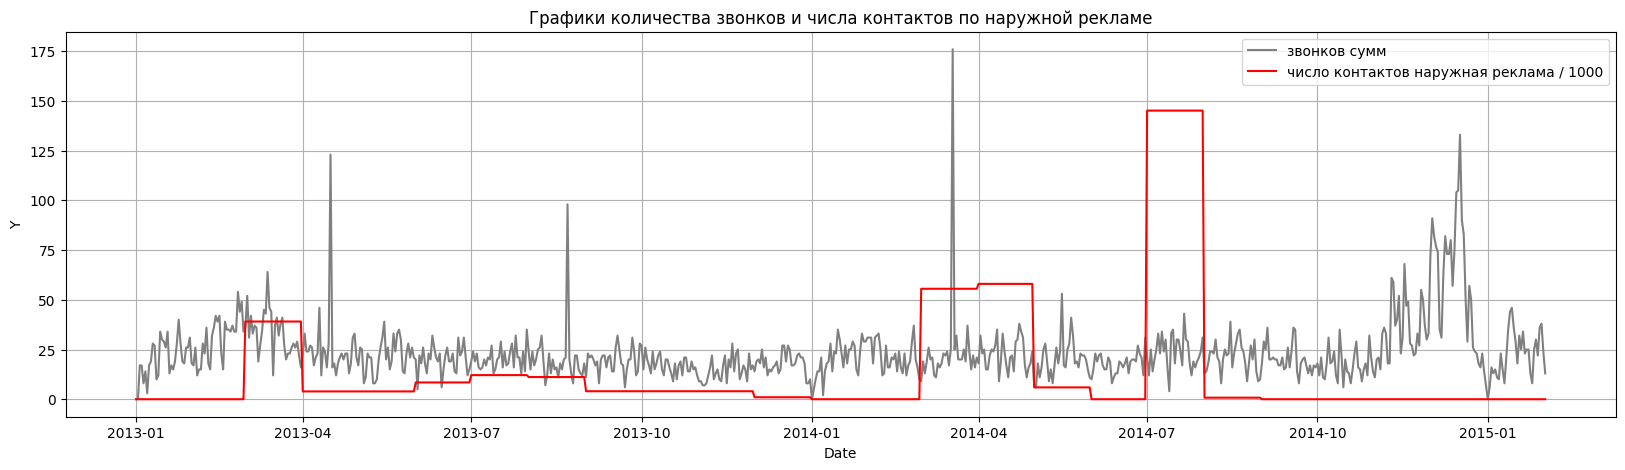

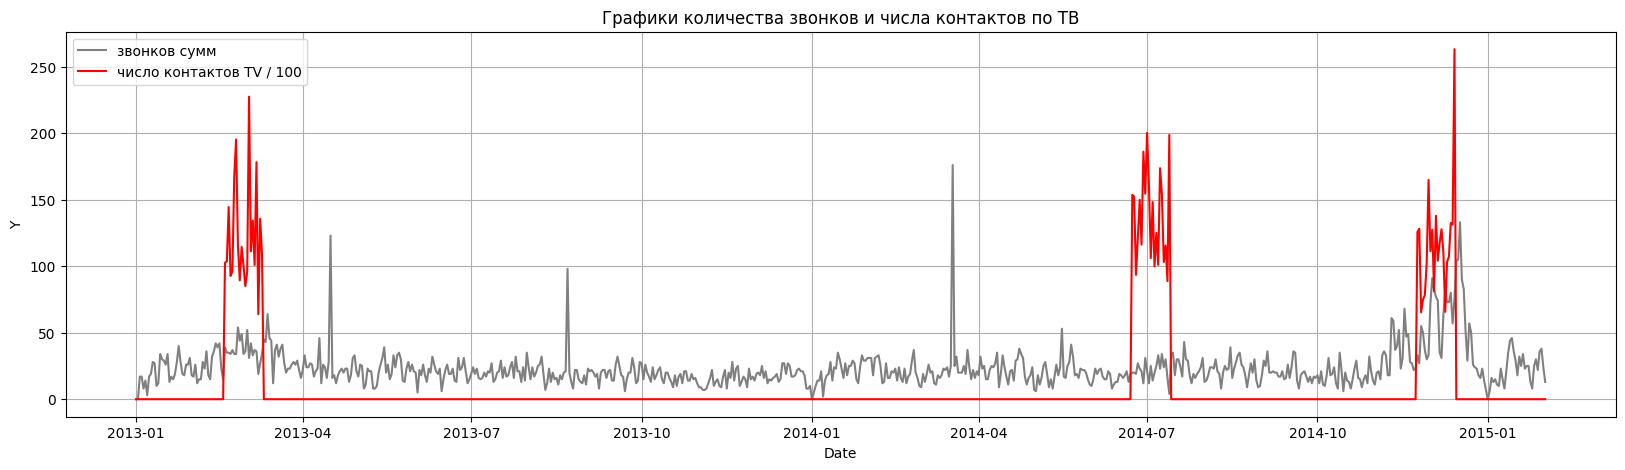

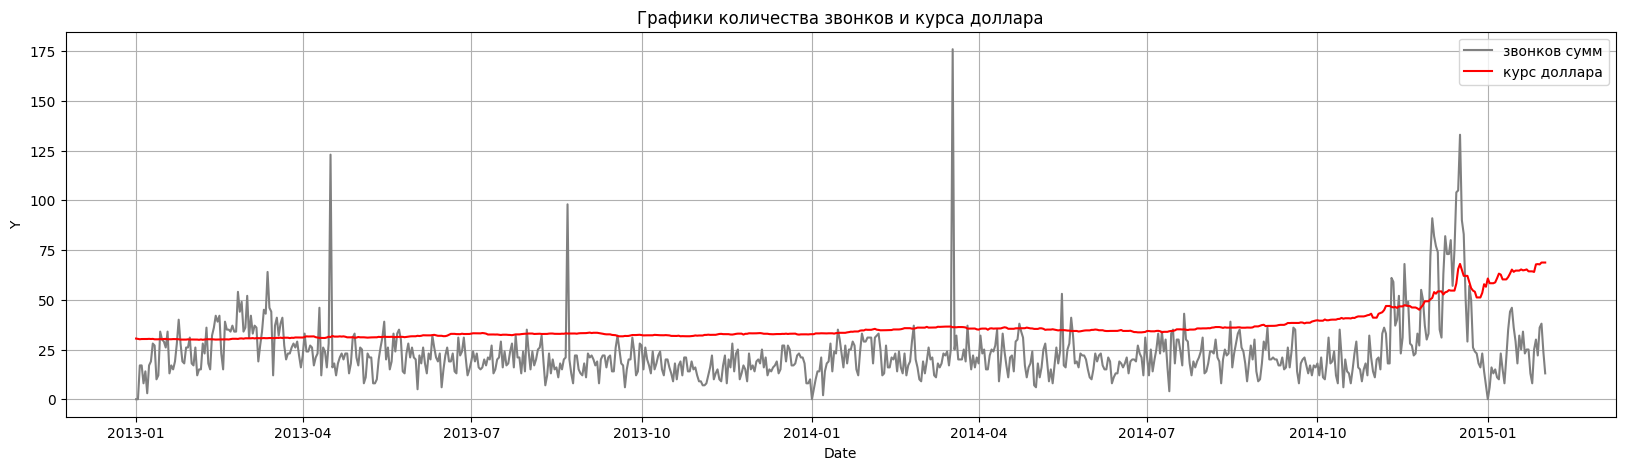

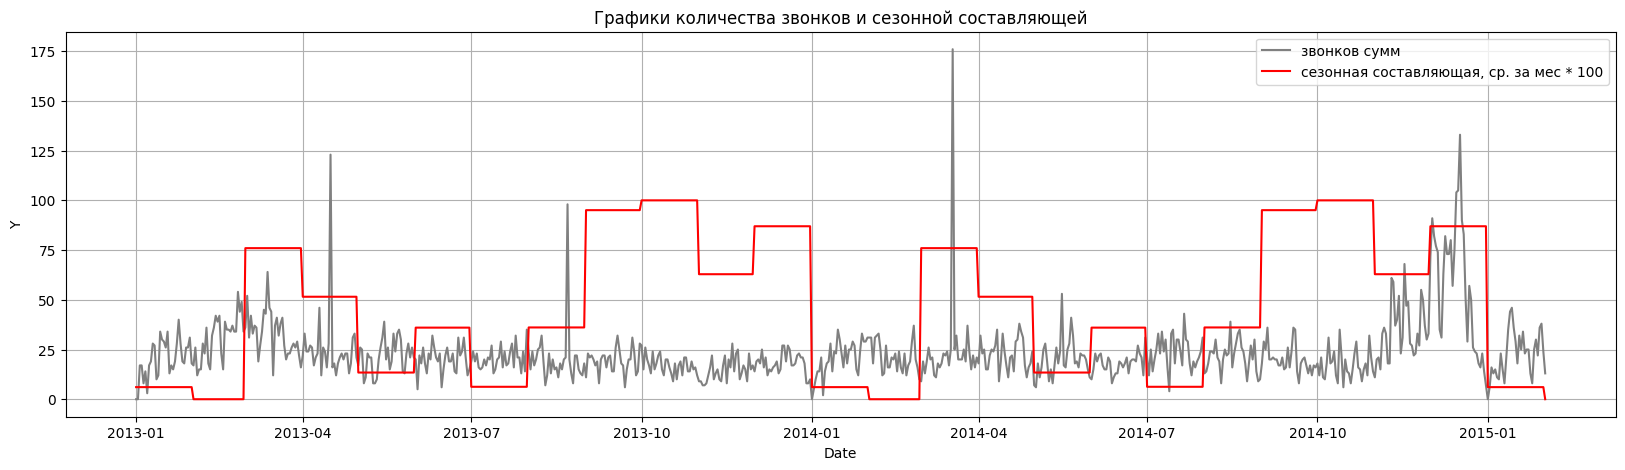

In [27]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(20, 5)
sns.lineplot(data = df, x=df.index, y='Y', color='grey', ax=plt.gca(), label='звонков сумм')
sns.lineplot(x=df.index, y=df['OOH']/1000, color='red', ax=plt.gca(), label='число контактов наружная реклама / 1000')
plt.title('Графики количества звонков и числа контактов по наружной рекламе')
plt.legend()
plt.grid()
plt.show()

f, ax = plt.subplots(1, 1)
f.set_size_inches(20, 5)
sns.lineplot(data = df, x=df.index, y='Y', color='grey', ax=plt.gca(), label='звонков сумм')
sns.lineplot(x=df.index, y=df['TV']/100, color='red', ax=plt.gca(), label='число контактов TV / 100')
plt.title('Графики количества звонков и числа контактов по ТВ')
plt.legend()
plt.grid()
plt.show()

f, ax = plt.subplots(1, 1)
f.set_size_inches(20, 5)
sns.lineplot(data = df, x=df.index, y='Y', color='grey', ax=plt.gca(), label='звонков сумм')
sns.lineplot(x=df.index, y=df['Usd_rate'], color='red', ax=plt.gca(), label='курс доллара')
plt.title('Графики количества звонков и курса доллара')
plt.legend()
plt.grid()
plt.show()

f, ax = plt.subplots(1, 1)
f.set_size_inches(20, 5)
sns.lineplot(data = df, x=df.index, y='Y', color='grey', ax=plt.gca(), label='звонков сумм')
sns.lineplot(x=df.index, y=df['Seasonal_Sales']*100, color='red', label='сезонная составляющая, ср. за мес * 100')
plt.title('Графики количества звонков и сезонной составляющей')
plt.legend()
plt.grid()
plt.show()

### Вывод:

Курс доллара:
- имеет сильную корреляцию со скачком количества звонков в ноябре-декабре 2014.

Наружная реклама:
- Увеличение контактов с аудиторией в марте-апреле 2014 совпадает со скачком количества суммарных звонков в этот же временной промежуток.

Число контактов по ТВ:
- Кажется, слабо влияет на количество звонков. В последней рекламной компании могло повлиять на рост количества звонков в совокупности с курсом доллара.

Число контактов по ТВ и Наружная реклама:
- в 2 случаях совпадают по времени с увеличением контактов через наружную рекламу. Возможно, их увеличение в марте 2013 повлияло на дальнейший пик в количестве звонков.

# Создание новых признаков

## Календарные признаки

Уже построены. Год, месяц и день недели.

In [28]:
df.head(1)

,Y,TV,OOH,Seasonal_Sales,Usd_rate,year,month,day_of_week
Date,,,,,,,,
2013-01-01,0,0,0.0,0.060802,30.502001,2013,1,1


## Отстающие значения

Построим график автокорреляции, чтобы выявить наиболее важные (коррелирующие с целевой переменной) для модели лаги:

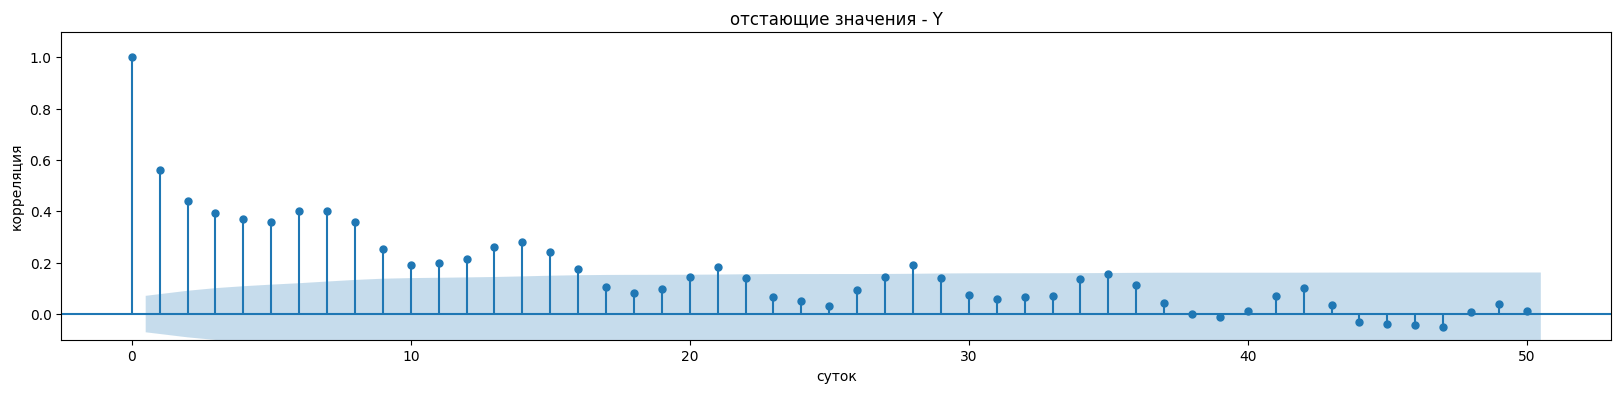

In [29]:
for i in ['Y']:
    fig = tsaplots.plot_acf(df[i], lags=50)
    fig.set_size_inches(20, 4)
    plt.title(f'отстающие значения - {i}')
    plt.ylim(-.1, 1.1)
    plt.ylabel('корреляция')
    plt.xlabel('суток')
    plt.show()

Какие отстающие признаки сделаем:
1. `Y` - 1, 2, 3, 7, 14
2. `TV` - 1, 7, 30
3. `OOH` - 1, 7, 30
4. `Seasonal_Sales` - 30
5. `Usd_rate` - 1, 3, 7, 30

In [30]:
for i in [1, 2, 3, 4, 5, 7, 8, 14, 21, 30]:
    df[f'Y_lag_{i}'] = df['Y'].shift(i)

for i in [1, 2, 3, 5, 7, 14]:
    df[f'TV_lag_{i}'] = df['TV'].shift(i)

df['OOH_lag_30'] = df['OOH'].shift(21)

# Рост доллара:
df['Usd_rate_growth_d'] = (df['Usd_rate'] - df['Usd_rate'].shift(1))**2

#df['Usd_rate_growth_w'] = df['Usd_rate'] - df['Usd_rate'].shift(7)
#df['Usd_rate_growth_week'] = df['Usd_rate'] - df['Usd_rate'].shift(7)
#df['Usd_rate_growth_2week'] = df['Usd_rate'] - df['Usd_rate'].shift(14)
    
df.head()

,Y,TV,OOH,Seasonal_Sales,Usd_rate,year,month,day_of_week,Y_lag_1,Y_lag_2,...,Y_lag_21,Y_lag_30,TV_lag_1,TV_lag_2,TV_lag_3,TV_lag_5,TV_lag_7,TV_lag_14,OOH_lag_30,Usd_rate_growth_d
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0,0,0.0,0.060802,30.502001,2013,1,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,0,0,0.0,0.060802,30.337200,2013,1,2,0.0,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.027159
2013-01-03,17,0,0.0,0.060802,30.156500,2013,1,3,0.0,0.0,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.032652
2013-01-04,17,0,0.0,0.060802,30.271000,2013,1,4,17.0,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.013110
2013-01-05,8,0,0.0,0.060802,30.271000,2013,1,5,17.0,17.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.000000


## Скользящее среднее:

In [31]:
#for i in [7]:
#    df[f'Y_{i}_mean'] = df['Y_lag_1'].rolling(i).mean()
#df['Y_1_min_w'] = df['Y_lag_1'].rolling(7).min()

df = df.drop('year', axis=1)
df = df.drop('month', axis=1)

df.head()

,Y,TV,OOH,Seasonal_Sales,Usd_rate,day_of_week,Y_lag_1,Y_lag_2,Y_lag_3,Y_lag_4,...,Y_lag_21,Y_lag_30,TV_lag_1,TV_lag_2,TV_lag_3,TV_lag_5,TV_lag_7,TV_lag_14,OOH_lag_30,Usd_rate_growth_d
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0,0,0.0,0.060802,30.502001,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,0,0,0.0,0.060802,30.337200,2,0.0,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.027159
2013-01-03,17,0,0.0,0.060802,30.156500,3,0.0,0.0,NaN,NaN,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.032652
2013-01-04,17,0,0.0,0.060802,30.271000,4,17.0,0.0,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.013110
2013-01-05,8,0,0.0,0.060802,30.271000,5,17.0,17.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.000000


## Итог:

- Теперь у нас 28 признаков.
- Появились пустые значения. Придется их удалить

## Удаление пропусков

In [32]:
print ('Процент оставшегося после удаления датасета: \n', round(len(df.dropna())/len(df)*100, 2))
print ('Строк до удаления:', len(df))

df = df.dropna()

print ('Строк после удаления:', len(df))

Процент оставшегося после удаления датасета: 
 96.06
Строк до удаления: 762
Строк после удаления: 732


# Корреляционный анализ

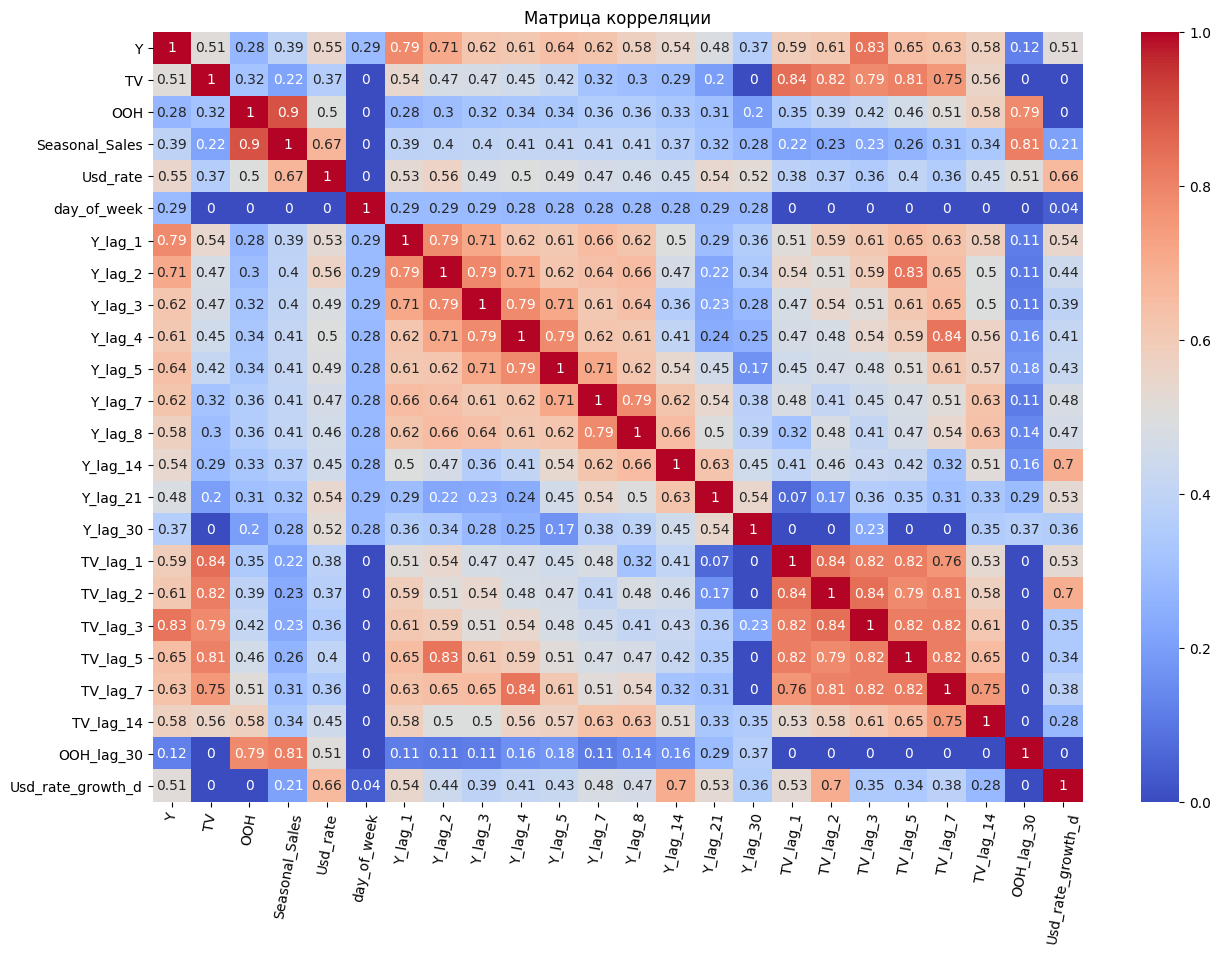

In [33]:
cor_matrix = df.phik_matrix(interval_cols=df.columns)

figsize = (10,10)
fig, ax = plt.subplots(figsize=(15,10))
plt.title('Матрица корреляции')
sns.heatmap(cor_matrix, ax=ax, annot=True, fmt='.2g', cmap='coolwarm')
plt.xticks(rotation=80)
plt.show()

## Мультиколлинеарность

In [34]:
# ищем признаки с мультиколлинеарностью
bad_cols = ['Y']
for i in df.columns:
  if (cor_matrix[i]>0.90).sum() >= 2:
    bad_cols.append(i)
print ('Признаки с мультиколлинеарностью:\n', bad_cols)

Признаки с мультиколлинеарностью:
 ['Y', 'OOH', 'Seasonal_Sales']


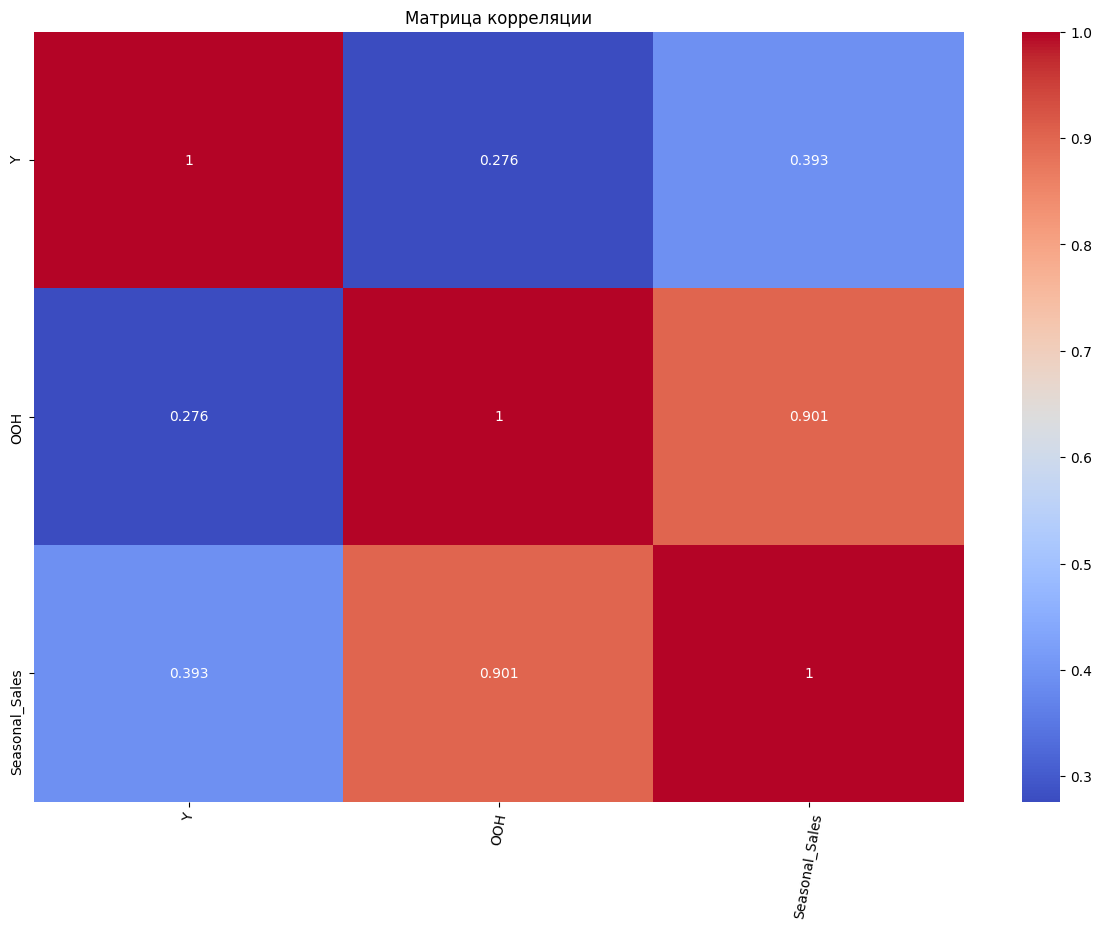

In [35]:
figsize = (8,8)
fig, ax = plt.subplots(figsize=(15,10))
plt.title('Матрица корреляции')
sns.heatmap(cor_matrix.loc[bad_cols, bad_cols], ax=ax, annot=True, fmt='.3g', cmap='coolwarm')
plt.xticks(rotation=80)
plt.show()

Удаляем ООН, оставляем ООН лаг 30.

In [36]:
df = df.drop('OOH', axis=1)

## Итог: матрица корреляции

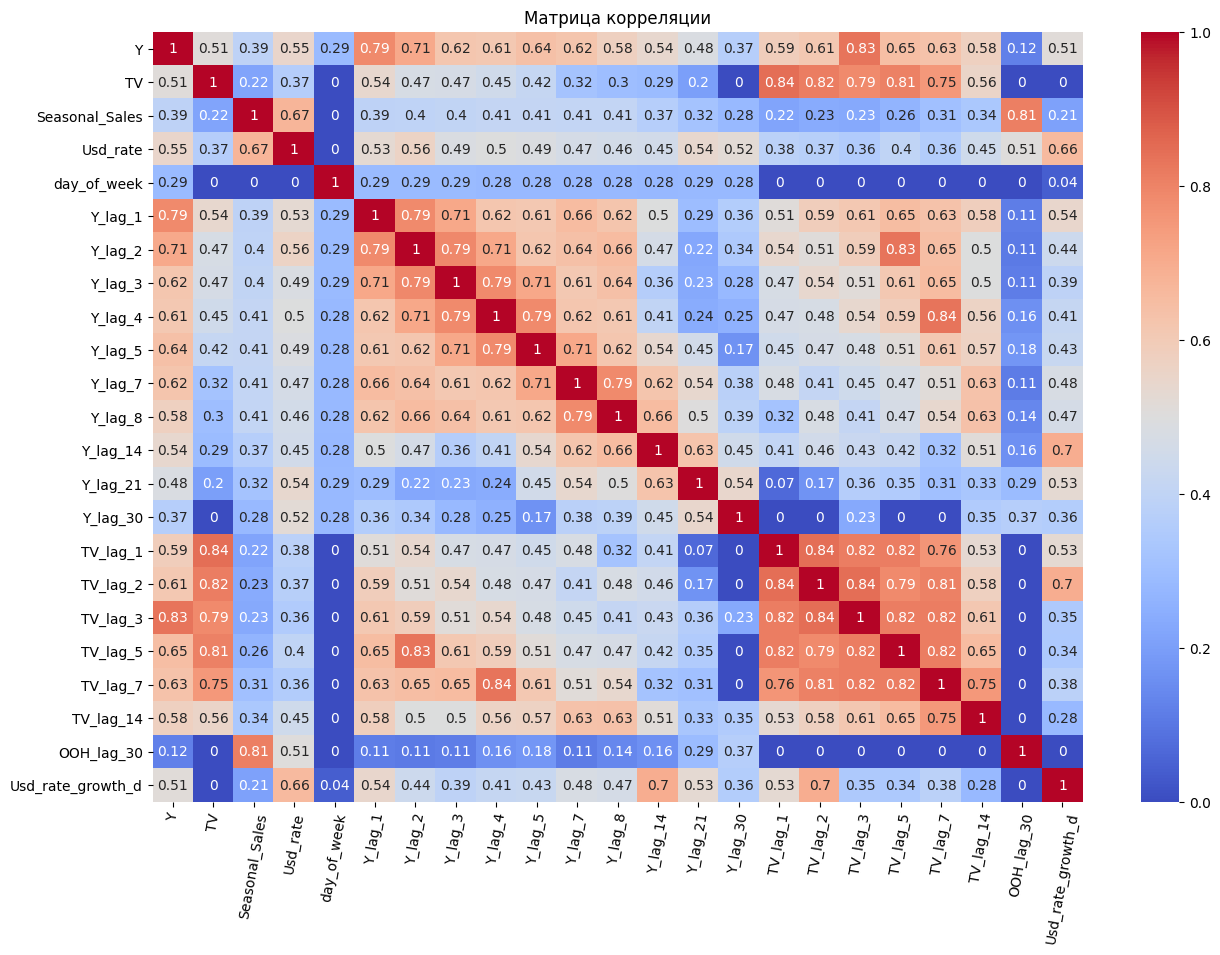

In [37]:
cor_matrix = df.phik_matrix(interval_cols=df.columns)

figsize = (10,10)
fig, ax = plt.subplots(figsize=(15,10))
plt.title('Матрица корреляции')
sns.heatmap(cor_matrix, ax=ax, annot=True, fmt='.2g', cmap='coolwarm')
plt.xticks(rotation=80)
plt.show()

**Вывод:**

Мультиколлинеарность устранена.

Все признаки имеют достаточную корреляцию с целевым признаком. 

Можно строить модели.

# Обучение

## Выбор метрики

Воспользуемся метрикой MAE, т.к. у нас есть несколько серьезных по величине выбросов, а она наиболее устойчива к ним.

## Разбивка на выборки

In [38]:
X = df.drop('Y', axis=1)
y = df['Y']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False, random_state=RANDOM_STATE)

for i in [X_train, X_test, y_train, y_test]:
    print (f'shape {i.shape} \n min {i.index.min()} \n max {i.index.max()}\n')

shape (549, 22) 
 min 2013-01-31 00:00:00 
 max 2014-08-02 00:00:00

shape (183, 22) 
 min 2014-08-03 00:00:00 
 max 2015-02-01 00:00:00

shape (549,) 
 min 2013-01-31 00:00:00 
 max 2014-08-02 00:00:00

shape (183,) 
 min 2014-08-03 00:00:00 
 max 2015-02-01 00:00:00



Данные разбиты на выборки верно:

- размерности X и y совпадают
- максимальные индексы тренировочных выборок меньше минимальных индексов тестовых выборок

## LinearRegression

In [40]:
num_columns = X_train.columns

In [41]:
data_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_columns),
],
    remainder='passthrough'
)

In [42]:
#pipe = Pipeline([('procession', data_preprocessor), ('models', LinearRegression())])
pipe = Pipeline([('models', LinearRegression())])

param_grid = [
    #{'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
     #'models__max_depth': range(2, 20), 'models__max_features': range(3, 25),},
    {'models': [LinearRegression()]} 
]

# Создадим RMSE в качестве пользовательской метрики, чтобы подсчет в переборе происходил сразу по ней
mae = make_scorer(mean_absolute_error, greater_is_better=False)

# В cv указываем TimeSeriesSplit, чтобы данные разбивались на подвыборки не перемешиваясь, по временным периодам
grid_search = GridSearchCV(pipe, param_grid, cv=TimeSeriesSplit(n_splits=2), scoring=mae, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Сохраняем лучшую модель и таблицу с результатами
lr_best_model = grid_search.best_estimator_
grid_results = pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score', ascending=False)

# Сохраняем среднее время обучения, предсказания и значения метрики лучшей модели
lr_best = grid_results[['mean_fit_time', 'mean_score_time', 'mean_test_score']].head(1)

In [43]:
print ('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('\nМетрика лучшей модели при кросс-валидации:\n', round(-grid_search.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('models', LinearRegression())])

Метрика лучшей модели при кросс-валидации:
 7.01


## LightGBM Regressor

In [44]:
model = LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbosity= -1)

parameters = {'n_estimators': optuna.distributions.IntDistribution(10, 2000),
              #'boosting_type': distributions.CategoricalDistribution(choices=('gbdt', 'dart')),
              #'subsample_for_bin ': distributions.IntDistribution(1, 20000),
              #'reg_lambda': distributions.IntDistribution(0, 200),
              'learning_rate': optuna.distributions.FloatDistribution(0.03, 1.0)
              #'max_depth': distributions.IntDistribution(4, 300)
             }

lgbm_cv = OptunaSearchCV(model,
                         parameters,
                         scoring='neg_mean_absolute_error',
                         cv=3,
                         n_trials=20,
                         random_state=RANDOM_STATE)

lgbm_cv.fit(X_train, y_train)

C:\Users\Денис\AppData\Local\Temp\ipykernel_16072\97280366.py:11: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  lgbm_cv = OptunaSearchCV(model,
[I 2025-05-20 01:57:56,221] A new study created in memory with name: no-name-b66b7420-bec9-41c3-9682-d10784245e1e
[I 2025-05-20 01:58:01,216] Trial 0 finished with value: -8.049071970781357 and parameters: {'n_estimators': 1710, 'learning_rate': 0.39344331390243914}. Best is trial 0 with value: -8.049071970781357.
[I 2025-05-20 01:58:06,975] Trial 1 finished with value: -8.134849282742474 and parameters: {'n_estimators': 1203, 'learning_rate': 0.6748250543698919}. Best is trial 0 with value: -8.049071970781357.
[I 2025-05-20 01:58:12,193] Trial 2 finished with value: -7.874046280532237 and parameters: {'n_estimators': 1627, 'learning_rate': 0.07386635189951823}. Best is trial 2 with value: -7.874046280532237.
[I 2025-05-20 01:58:12,633] Trial 3 finished with value: -8.982

OptunaSearchCV(cv=3,
               estimator=LGBMRegressor(n_jobs=-1, random_state=30,
                                       verbosity=-1),
               n_jobs=1, n_trials=20,
               param_distributions={'learning_rate': FloatDistribution(high=1.0, log=False, low=0.03, step=None),
                                    'n_estimators': IntDistribution(high=2000, log=False, low=10, step=1)},
               random_state=30, scoring='neg_mean_absolute_error')

In [45]:
lgbm_cv_best = lgbm_cv.best_score_
lgbm_cv_best

-7.706746691275842

## CatBoost

In [46]:
model = CatBoostRegressor(loss_function='RMSE', silent=True)

parameters = {'iterations' : distributions.IntDistribution(200, 500),
        'learning_rate': distributions.FloatDistribution(0.03, 0.6),
        'l2_leaf_reg': distributions.IntDistribution(5, 20),
        'depth': distributions.IntDistribution(1, 16)
    }

catboost_cv = OptunaSearchCV(model, parameters, cv=3, n_trials=5, scoring='neg_mean_absolute_error', random_state=RANDOM_STATE)

catboost_cv.fit(X_train, y_train)

C:\Users\Денис\AppData\Local\Temp\ipykernel_16072\1153254136.py:9: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  catboost_cv = OptunaSearchCV(model, parameters, cv=3, n_trials=5, scoring='neg_mean_absolute_error', random_state=RANDOM_STATE)
[I 2025-05-20 01:58:49,423] A new study created in memory with name: no-name-b6db5ba3-fd01-47aa-9dfb-28bd1f5076ee
[I 2025-05-20 02:00:07,785] Trial 0 finished with value: -6.685027515402578 and parameters: {'iterations': 457, 'learning_rate': 0.24356978239627866, 'l2_leaf_reg': 14, 'depth': 11}. Best is trial 0 with value: -6.685027515402578.
[I 2025-05-20 02:05:16,688] Trial 1 finished with value: -6.643783669745055 and parameters: {'iterations': 444, 'learning_rate': 0.05577713462136638, 'l2_leaf_reg': 5, 'depth': 13}. Best is trial 1 with value: -6.643783669745055.
[I 2025-05-20 02:09:00,062] Trial 2 finished with value: -6.647373626836813 and parameters: {'iterations': 324

OptunaSearchCV(cv=3,
               estimator=<catboost.core.CatBoostRegressor object at 0x000002164553B4C0>,
               n_jobs=1, n_trials=5,
               param_distributions={'depth': IntDistribution(high=16, log=False, low=1, step=1),
                                    'iterations': IntDistribution(high=500, log=False, low=200, step=1),
                                    'l2_leaf_reg': IntDistribution(high=20, log=False, low=5, step=1),
                                    'learning_rate': FloatDistribution(high=0.6, log=False, low=0.03, step=None)},
               random_state=30, scoring='neg_mean_absolute_error')

In [47]:
cat_cv_best = catboost_cv.best_score_
cat_cv_best

-6.643783669745055

# Обучение без выбросов:

## Устранение выбросов

В обучающей выборке имели 3 необъяснимых, сильных выброса. Попробуем их устранить и посмотрим, как от этого изменится метрика.

Для начала выведем на экран индексы этих выбросов:

In [48]:
data = df.copy()

indexes_for_big = []
for i in data.loc[:'2014-04', :].index:
    if data.loc[i, 'Y']>75:
        indexes_for_big.append(i)
data.loc[indexes_for_big, 'Y']

Date
2013-04-16    123
2013-08-22     98
2014-03-18    176
Name: Y, dtype: int32

Присвоим им значение целевой переменной недельной давности:

In [49]:
data.loc[indexes_for_big, 'Y'] = data.loc[indexes_for_big, 'Y_lag_7']
data['Y'] = data['Y'].astype('int')
data.loc[indexes_for_big, 'Y']

Date
2013-04-16    23
2013-08-22    15
2014-03-18    16
Name: Y, dtype: int32

## Разбивка на тест и трейн

In [50]:
X = data.drop('Y', axis=1)
y = data['Y']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False, random_state=RANDOM_STATE)

for i in [X_train, X_test, y_train, y_test]:
    print (f'shape {i.shape} \n min {i.index.min()} \n max {i.index.max()}\n')

shape (549, 22) 
 min 2013-01-31 00:00:00 
 max 2014-08-02 00:00:00

shape (183, 22) 
 min 2014-08-03 00:00:00 
 max 2015-02-01 00:00:00

shape (549,) 
 min 2013-01-31 00:00:00 
 max 2014-08-02 00:00:00

shape (183,) 
 min 2014-08-03 00:00:00 
 max 2015-02-01 00:00:00



## LinearRegression 2


In [52]:
#pipe = Pipeline([('procession', data_preprocessor), ('models', LinearRegression())])
pipe = Pipeline([('models', LinearRegression())])

param_grid = [
    #{'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
    # 'models__max_depth': range(2, 20), 'models__max_features': range(3, 25),},
    {'models': [LinearRegression()]} 
]

# В cv указываем TimeSeriesSplit, чтобы данные разбивались на подвыборки не перемешиваясь, по временным периодам
grid_search_2 = GridSearchCV(pipe, param_grid, cv=TimeSeriesSplit(n_splits=4), scoring=mae, n_jobs=-1)
grid_search_2.fit(X_train, y_train)

# Сохраняем лучшую модель и таблицу с результатами
lr_best_model_2 = grid_search_2.best_estimator_
grid_results_2 = pd.DataFrame(grid_search_2.cv_results_).sort_values(by='mean_test_score', ascending=False)

# Сохраняем среднее время обучения, предсказания и значения метрики лучшей модели
lr_best_2 = grid_results_2[['mean_fit_time', 'mean_score_time', 'mean_test_score']].head(1)

In [53]:
print ('Лучшая модель и её параметры:\n\n', grid_search_2.best_estimator_)
print ('\nМетрика лучшей модели при кросс-валидации:\n', round(-grid_search_2.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('models', LinearRegression())])

Метрика лучшей модели при кросс-валидации:
 5.88


## LGBMRegressor 2

In [54]:
model = LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbosity= -1)

parameters = {'n_estimators': optuna.distributions.IntDistribution(10, 2000),
              #'boosting_type': distributions.CategoricalDistribution(choices=('gbdt', 'dart')),
              #'subsample_for_bin ': distributions.IntDistribution(1, 20000),
              #'reg_lambda': distributions.IntDistribution(0, 200),
              'learning_rate': optuna.distributions.FloatDistribution(0.03, 1.0)
              #'max_depth': distributions.IntDistribution(4, 300)
             }

lgbm_cv_2 = OptunaSearchCV(model,
                         parameters,
                         scoring='neg_mean_absolute_error',
                         cv=3,
                         n_trials=20,
                         random_state=RANDOM_STATE)

lgbm_cv_2.fit(X_train, y_train)

C:\Users\Денис\AppData\Local\Temp\ipykernel_16072\2335037646.py:11: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  lgbm_cv_2 = OptunaSearchCV(model,
[I 2025-05-20 02:11:06,439] A new study created in memory with name: no-name-6934b5d4-067e-474b-ada2-c59276a9d58e
[I 2025-05-20 02:11:09,654] Trial 0 finished with value: -6.675605819974035 and parameters: {'n_estimators': 1710, 'learning_rate': 0.39344331390243914}. Best is trial 0 with value: -6.675605819974035.
[I 2025-05-20 02:11:11,735] Trial 1 finished with value: -6.70702488059026 and parameters: {'n_estimators': 1203, 'learning_rate': 0.6748250543698919}. Best is trial 0 with value: -6.675605819974035.
[I 2025-05-20 02:11:14,385] Trial 2 finished with value: -6.296444771213724 and parameters: {'n_estimators': 1627, 'learning_rate': 0.07386635189951823}. Best is trial 2 with value: -6.296444771213724.
[I 2025-05-20 02:11:14,673] Trial 3 finished with value: -7.

OptunaSearchCV(cv=3,
               estimator=LGBMRegressor(n_jobs=-1, random_state=30,
                                       verbosity=-1),
               n_jobs=1, n_trials=20,
               param_distributions={'learning_rate': FloatDistribution(high=1.0, log=False, low=0.03, step=None),
                                    'n_estimators': IntDistribution(high=2000, log=False, low=10, step=1)},
               random_state=30, scoring='neg_mean_absolute_error')

In [55]:
lgbm_cv_best_2 = lgbm_cv_2.best_score_
lgbm_cv_best_2

-6.189886316640332

## CatBoost 2

In [56]:
model = CatBoostRegressor(loss_function='RMSE', silent=True)

parameters = {'iterations' : distributions.IntDistribution(200, 500),
        'learning_rate': distributions.FloatDistribution(0.03, 0.6),
        'l2_leaf_reg': distributions.IntDistribution(5, 20),
        'depth': distributions.IntDistribution(1, 16)
    }

catboost_cv_2 = OptunaSearchCV(model, parameters, cv=3, n_trials=5, scoring='neg_mean_absolute_error', random_state=RANDOM_STATE)

catboost_cv_2.fit(X_train, y_train)

C:\Users\Денис\AppData\Local\Temp\ipykernel_16072\1987412789.py:9: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  catboost_cv_2 = OptunaSearchCV(model, parameters, cv=3, n_trials=5, scoring='neg_mean_absolute_error', random_state=RANDOM_STATE)
[I 2025-05-20 02:11:38,047] A new study created in memory with name: no-name-0603a9ba-cc1c-45ff-a5f6-c2e5cf4e215b
[I 2025-05-20 02:13:05,912] Trial 0 finished with value: -6.142410882763727 and parameters: {'iterations': 457, 'learning_rate': 0.24356978239627866, 'l2_leaf_reg': 14, 'depth': 11}. Best is trial 0 with value: -6.142410882763727.
[I 2025-05-20 02:18:15,480] Trial 1 finished with value: -6.041176184012246 and parameters: {'iterations': 444, 'learning_rate': 0.05577713462136638, 'l2_leaf_reg': 5, 'depth': 13}. Best is trial 1 with value: -6.041176184012246.
[I 2025-05-20 02:21:56,411] Trial 2 finished with value: -6.032583000299691 and parameters: {'iterations': 3

OptunaSearchCV(cv=3,
               estimator=<catboost.core.CatBoostRegressor object at 0x0000021645483B50>,
               n_jobs=1, n_trials=5,
               param_distributions={'depth': IntDistribution(high=16, log=False, low=1, step=1),
                                    'iterations': IntDistribution(high=500, log=False, low=200, step=1),
                                    'l2_leaf_reg': IntDistribution(high=20, log=False, low=5, step=1),
                                    'learning_rate': FloatDistribution(high=0.6, log=False, low=0.03, step=None)},
               random_state=30, scoring='neg_mean_absolute_error')

In [57]:
cat_cv_best_2 = catboost_cv_2.best_score_
cat_cv_best_2

-5.851237160862339

## CatBoost 3

In [58]:
model = CatBoostRegressor(loss_function='MAE', silent=True)

parameters = {'iterations' : distributions.IntDistribution(100, 500),
        'learning_rate': distributions.FloatDistribution(0.03, 1),
        'l2_leaf_reg': distributions.IntDistribution(5, 20),
        'depth': distributions.IntDistribution(1, 16)
    }

catboost_cv_3 = OptunaSearchCV(model, parameters, cv=3, n_trials=10, scoring='neg_mean_absolute_error', random_state=RANDOM_STATE)

catboost_cv_3.fit(X_train, y_train)

C:\Users\Денис\AppData\Local\Temp\ipykernel_16072\252044998.py:9: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  catboost_cv_3 = OptunaSearchCV(model, parameters, cv=3, n_trials=10, scoring='neg_mean_absolute_error', random_state=RANDOM_STATE)
[I 2025-05-20 02:21:59,651] A new study created in memory with name: no-name-8c4cf00a-96ef-41b7-9459-7c29db5e594f
[I 2025-05-20 02:23:14,890] Trial 0 finished with value: -6.327955777806864 and parameters: {'iterations': 442, 'learning_rate': 0.39344331390243914, 'l2_leaf_reg': 14, 'depth': 11}. Best is trial 0 with value: -6.327955777806864.
[I 2025-05-20 02:28:25,667] Trial 1 finished with value: -6.095153736928423 and parameters: {'iterations': 425, 'learning_rate': 0.07386635189951823, 'l2_leaf_reg': 5, 'depth': 13}. Best is trial 1 with value: -6.095153736928423.
[I 2025-05-20 02:31:33,107] Trial 2 finished with value: -6.230820610608536 and parameters: {'iterations': 2

OptunaSearchCV(cv=3,
               estimator=<catboost.core.CatBoostRegressor object at 0x00000216455B5550>,
               n_jobs=1,
               param_distributions={'depth': IntDistribution(high=16, log=False, low=1, step=1),
                                    'iterations': IntDistribution(high=500, log=False, low=100, step=1),
                                    'l2_leaf_reg': IntDistribution(high=20, log=False, low=5, step=1),
                                    'learning_rate': FloatDistribution(high=1.0, log=False, low=0.03, step=None)},
               random_state=30, scoring='neg_mean_absolute_error')

In [59]:
cat_cv_best_3 = catboost_cv_3.best_score_
cat_cv_best_3

-5.988778330238257

# Выбор модели

In [60]:
print('Метрики на CV:')
print('LR1: ', round(-grid_search.best_score_, 2))
print('LGBM1: ', round(lgbm_cv_best, 2))
print('CB1: ', round(cat_cv_best, 2))
print('LR2: ', round(-grid_search_2.best_score_, 2))
print('LGBM2: ', round(lgbm_cv_best_2, 2))
print('CB2: ', round(cat_cv_best_2, 2))
print('CB3: ', round(cat_cv_best_3, 2))

Метрики на CV:
LR1:  7.01
LGBM1:  -7.71
CB1:  -6.64
LR2:  5.88
LGBM2:  -6.19
CB2:  -5.85
CB3:  -5.99


**Решение:**

Выбираем CatBoost 2 как показавшую лучшее значение метрики на кросс-валидации.

# Проверка на Test

In [61]:
preds = catboost_cv_2.predict(X_test)

In [62]:
print('MAE = ', -round(cat_cv_best_2, 2), '  - на кросс-валидации')
print ('MAE = ', round(mean_absolute_error(y_test, preds), 2), ' - на тесте')

MAE =  5.85   - на кросс-валидации
MAE =  11.76  - на тесте


- метрика на тесте значительно упала. Вероятно, это связано с резким ростом целевой переменной в декабре 2014.

# Анализ модели

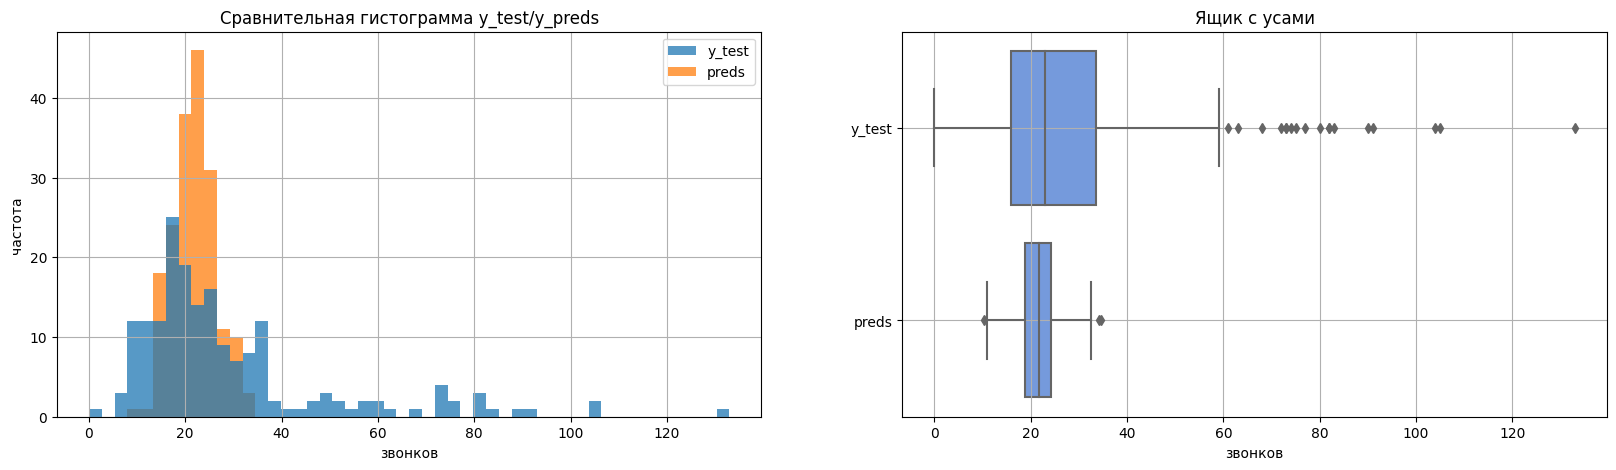

,count,mean,std,min,25%,50%,75%,max
y_test,183.0,29.256831,21.360965,0.000000,16.000000,23.000000,33.500000,133.00000
preds,183.0,21.796037,4.546145,10.390663,18.770941,21.728403,24.283786,34.54089


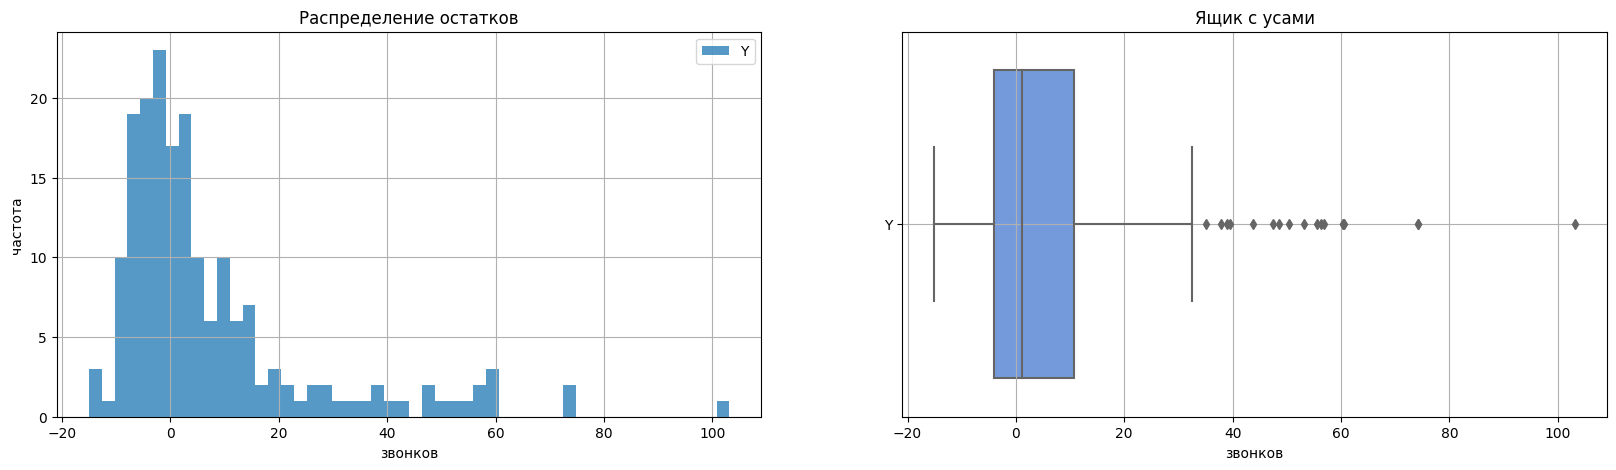

,count,mean,std,min,25%,50%,75%,max
Y,183.0,7.460793,18.826063,-15.044023,-4.115111,1.198929,10.757674,103.172842


In [63]:
build_joint_hist(y_test, preds, '', 'Сравнительная гистограмма y_test/y_preds')
make_hist(pd.DataFrame(y_test-preds), None, 50, '', 'звонков', 'Распределение остатков')
display(pd.DataFrame(y_test-preds).describe().T)

**Выводы:**
___________
**Сравнительная гистограмма:**

Распределение значений модели близко к нормальному, в отличие от реальных данных, где значения распределены не очень равномерно.

Заметно ниже стандартное отклонение предсказанных значений: 4.5 против 21. 

______
**Распределение остатков:**

Чаще модель преуменьшает значения.

Медиана распределения остатков - 1.2, довольно близко к нулю.   
При этом среднее - 7.46, достаточно далеко от нуля.  
- увеличение среднего остатков связано с тем, что модель плохо предсказала очень высокие значения декабря 2014 - при обучении она с такими значениями не сталкивалась.

Максимальное завышение количества звонков - 15.

___________


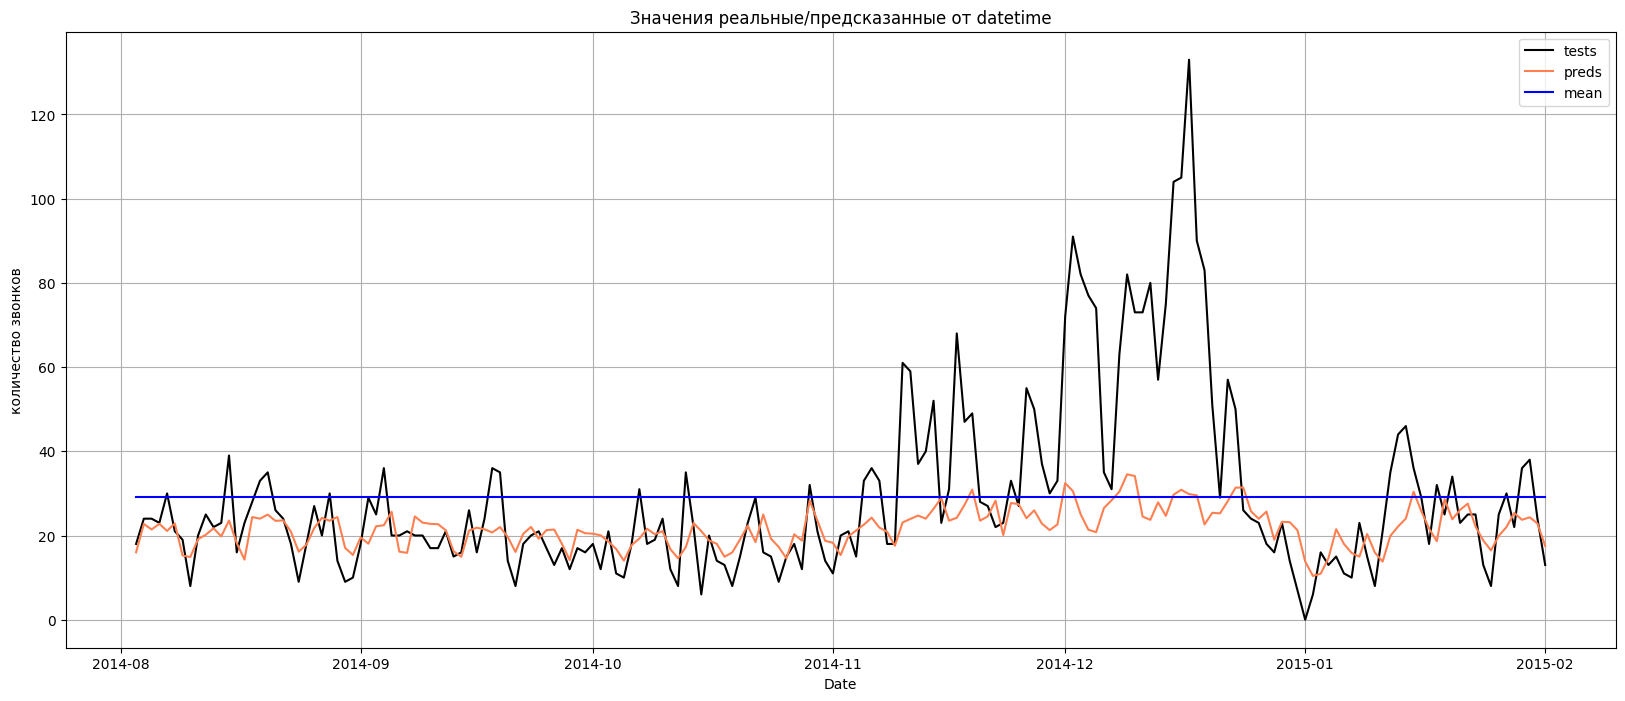

In [64]:
meanses = []
for i in y_test:
    meanses.append(y_test.mean())

f, ax = plt.subplots(1, 1)
f.set_size_inches(20, 8)
sns.lineplot(data = X_test, x=X_test.index, y=y_test, color='black', label='tests')
sns.lineplot(data = X_test, x=X_test.index, y=preds, color='coral', label='preds')
sns.lineplot(data = X_test, x=X_test.index, y=meanses, color='blue', label='mean')
plt.title('Значения реальные/предсказанные от datetime')
plt.ylabel('количество звонков')
plt.grid()
plt.show()

**Выводы:**

1. Сравнительно неплохо модель предсказывает значения в период до ноября 2014, когда начался резкий скачок звонков.

2. Модель не очень точна, но в основном верно определяет направления изменений количества звонков.

3. Модель не смогла предсказать сильный рост в ноябре-декабре 2014. Скорее всего, именно это значительно ухудшило метрику на тесте.

## Проверка на адекватность:

In [65]:
print ('MAE = ', round(mean_absolute_error(y_test, preds), 2), ' - предсказания модели')
print ('MAE = ', round(mean_absolute_error(y_test, meanses), 2), ' - предсказания константным средним значением')

MAE =  11.76  - предсказания модели
MAE =  14.97  - предсказания константным средним значением


- Видим, что модель чуть более эфеективна, чем если бы всегда предсказывали константой - средним.

## Анализ без учета скачка ноябрь-декабрь 2014

Берем значения только до ноября 2014 и с января 2015. Пересчитываем среднее для этого промежутка.

In [66]:
indexes = []
for i in y_test.index:
    if i<pd.to_datetime('2014-11-01'):
        indexes.append(i)
    if i>pd.to_datetime('2015-01-01'):
        indexes.append(i)

preds_ind = catboost_cv_2.predict(X_test.loc[indexes, :])

meanses_ind = []
for i in y_test[indexes]:
    meanses_ind.append(y_test[indexes].mean())

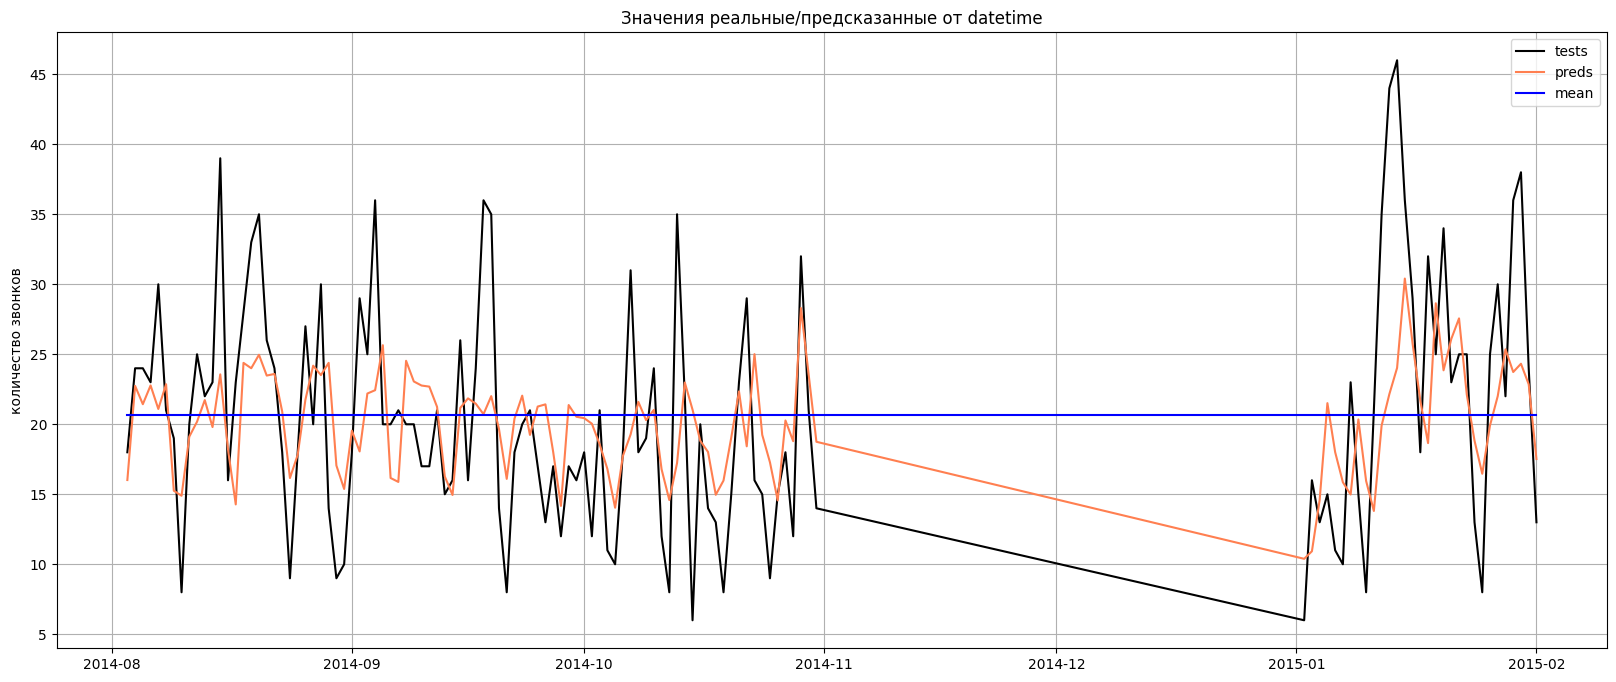

MAE =  5.61  - предсказания модели без учета ноября-декабря
MAE =  6.71  - предсказания константным средним значением без учета ноября-декабря


In [67]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(20, 8)
sns.lineplot(data = X_test.loc[indexes, :], x=indexes, y=y_test[indexes], color='black', label='tests')
sns.lineplot(data = X_test.loc[indexes, :], x=indexes, y=preds_ind, color='coral', label='preds')
sns.lineplot(data = X_test.loc[indexes, :], x=indexes, y=meanses_ind, color='blue', label='mean')
plt.title('Значения реальные/предсказанные от datetime')
plt.ylabel('количество звонков')
plt.grid()
plt.show()

print ('MAE = ', round(mean_absolute_error(y_test[indexes], preds_ind), 2), ' - предсказания модели без учета ноября-декабря')
print ('MAE = ', round(mean_absolute_error(y_test[indexes], meanses_ind), 2), 
       ' - предсказания константным средним значением без учета ноября-декабря')

### Вывод:

Метрика значительно выше без учета ноября-декабря - с теми месяцами модель явно не справляется.

При этом значение метрике все равно не сильне лучше, чем при предсказании константным средним значением.

Точно можно сказать, что модель неплохо предсказывает направление изменения количества звонков. В большинстве случаев справляется с определением пиковых количеством звонков (наибольших и наименьших). 

# Анализ важности признаков

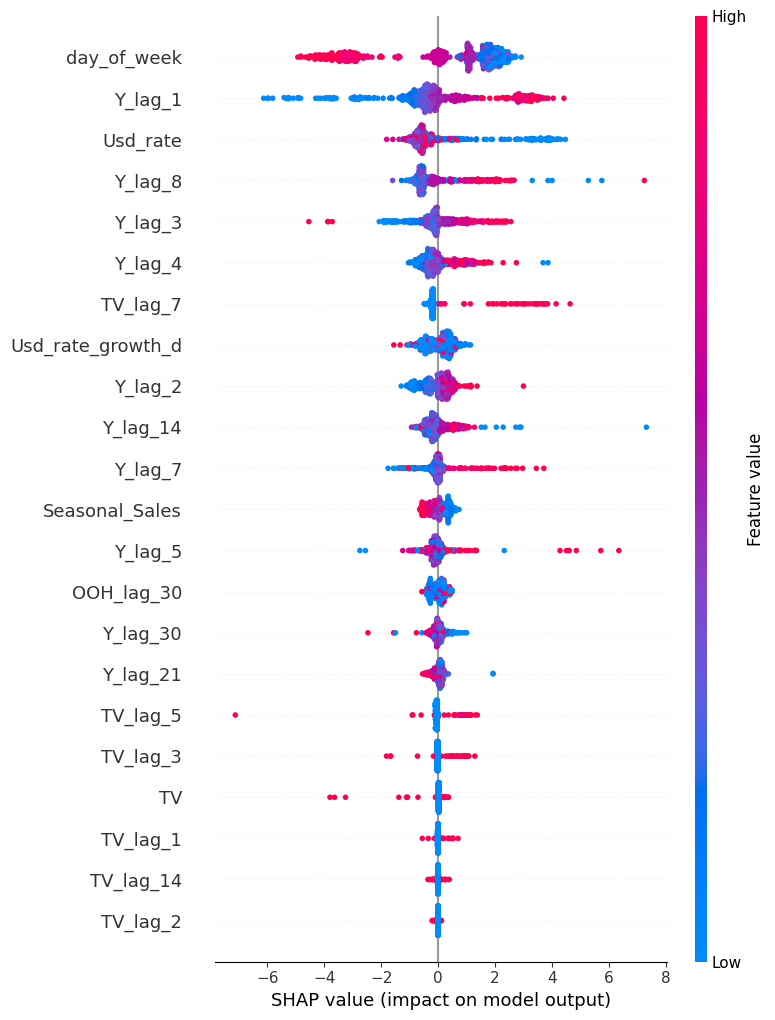

In [68]:
shap_values = shap.TreeExplainer(catboost_cv_2.best_estimator_).shap_values(X_train)
shap.summary_plot(shap_values, X_train, max_display=30)

**Наиболее важные с точки зрения модели признаки:**

Повышают значение целевой переменной *высокие* значения:
- количества звонков: вчерашнее, 3, 4, 5, 7, 8 дней назад
- количества контактов по ТВ: 7 дней назад

Повышают значение целевой переменной *низкие* значения:
- курса доллара
- количества звонков 30 дней назад
- оценки сезонной составляющей продаж

Изменение значения относительно среднего - повышает значение целевой переменной:
- TV, TV_lag_1, TV_lag_3, TV_lag_5, TV_lag_14

# Общий вывод

**Анализ данных:**

Данные представлены во временном промежутке 761 дня:
•	с 1 января 2013 по 1 февраля 2015

Всего было 3 рекламные кампании по ТВ: 17 февраля - 11 марта 2013 , 23 июня - 13 июля 2014, 24 ноября - 14 декабря. Оценка ежедневного количества с целевой аудиторией по этому каналу в дни кампании – от 5 до 26 млн контактов.

В первой ТВ-кампании корреляция с целевым признаком составила 0.284, во второй – 0.0, в третьей – 0.52.          
В 42% месяцев в представленном датасете число контактов по наружной рекламе равно нулю. Всего наружная реклама проводилась в 13 из 25 представленных в датасете месяцев. В среднем – 145.137 млн контактов в месяц. Пики – 2013: март; 2014: март, апрель, июль.


По большей части нормированная оценка сезонной составляющей продаж автомобиля не превышает значения 0.5. В половине случаев она ниже 0.36. Доля выше 0.5 в месяцах: март, апрель, сентябрь, октябрь, ноябрь, декабрь.  Видим наличие сезонности: 1) низкие значения в январе-феврале, 2) скачок в марте, 3) снижение к июлю, 4) повышение до пикового значения в октябре, 5) спад в январе.

Курс доллара начал явный рост после июля 2014. К февралю 2015 вырос примерно в два раза в сравнении с январем 2013. С этим ростом связан и сильный рост количества звонков в ноябре-декабре 2014.

На графике целевого признака от даты есть явные 3 явных выброса.  Видим сильный рост к концу 2013 года. Однако, его нельзя назвать устойчивым, т.к. в январе резко пошел на спад. 

Явно прослеживается сезонность по количеству звонков в течение недели: 
С понедельника по четверг включительно - количество звонков наибольшее. Пятница – спад. Выходные - низкое количество звонков.

_________________
**Создание признаков:**

Рост курса доллара:
- 'Usd_rate_growth_d' – как изменился курс в сравнении с предыдущим днем.

Отстающие значения:
Y – количество звонков (целевая переменная):
- 'Y_lag_{i}' – 1, 2, 3, 4, 5, 7, 8, 14, 21, 30 дней
  
TV – контакты через ТВ-рекламу:
- 'TV_lag_{i}' –  1, 2, 3, 5, 7, 14 дней
  
OOH – контакты через наружную рекламу:
- 'OOH_lag_30'  –  21 день

_________________
**Матрица корреляции:**

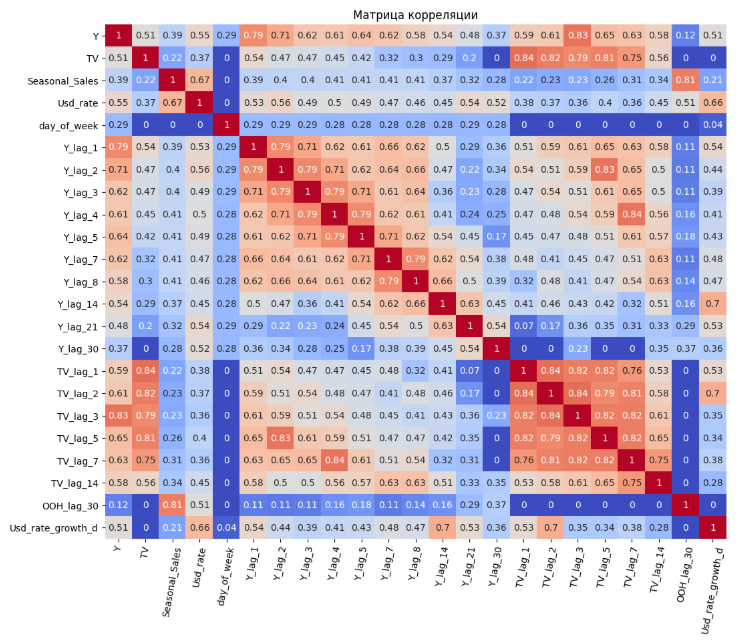


_____________
**Обучение моделей:**

Выбранная метрика:
- МАЕ – т.к. наименее чувствительна к выбросами и наиболее понятна для интерпретации.

Обучение моделей в два шага: с и без трех явных выбросов в данных.

**Результаты обучения с выбросами, метрика на кросс-валидации:**

LinearRegressor: 
- МАЕ = 7.01

LightGBM Regressor: 
- МАЕ = 7.70

CatBoostRegressor: 
- МАЕ = 6.64

**Результаты обучения без выбросов, метрика на кросс-валидации:**

LinearRegressor: 
- МАЕ = 5.88
  
LightGBM Regressor: 
- МАЕ = 6.19
  
CatBoostRegressor: 
- МАЕ = 5.85

**Лучшая модель:**

CatBoostRegressor:
- 'depth': =16, 'iterations': 500, 'l2_leaf_reg': 20, 'learning_rate': 0.6

______________
**Проверка на Тесте:**

- MAE =  11.76  - предсказания модели
- MAE =  14.97  - предсказания константным средним значением


**Анализ:**

Распределение значений модели близко к нормальному, в отличие от реальных данных, где значения распределены не очень равномерно.
Заметно ниже стандартное отклонение предсказанных значений: 4.5 против 21.

Чаще модель преуменьшает значения.    
Медиана распределения остатков - 1.2, довольно близко к нулю.        
При этом среднее - 7.46, достаточно далеко от нуля.      
- увеличение среднего остатков связано с тем, что модель плохо предсказала очень высокие значения декабря 2014 - при обучении она с такими значениями не сталкивалась.

Максимальное завышение количества звонков - 15.

1.	Сравнительно неплохо модель предсказывает значения в период до ноября 2014, когда начался резкий скачок звонков.
2.	Модель не очень точна, но в основном верно определяет направления изменений количества звонков.
3.	Модель не смогла предсказать сильный рост в ноябре-декабре 2014. Скорее всего, именно это значительно ухудшило метрику на тесте.



**Без учета ноября-декабря 2014:**

- MAE =  5.61  - предсказания модели без учета ноября-декабря
- MAE =  6.71  - предсказания константным средним значением без учета ноября-декабря

Вывод:
- Метрика значительно выше без учета ноября-декабря - с теми месяцами модель явно не справляется.
- При этом значение метрике все равно не сильне лучше, чем при предсказании константным средним значением.
- Точно можно сказать, что модель неплохо предсказывает направление изменения количества звонков. В большинстве случаев справляется с определением пиковых количеством звонков (наибольших и наименьших).

_____________________
**Возможности по улучшению модели:**

Добавить больше актуальных данных по 2015 году. 

Возможно, добавить новый категориальный признак: рост доллара на критический процент (50-100%) в последние день/неделю/месяц/2 месяца . В связи с резким ростом курса доллара в конце года покупательское поведение изменилось – такой признак поможет в дальнейшем учесть подобные изменения. Но для этого также нужно больше данных.

Если есть другие рекламные активности – учесть и их.

С имеющимся набором – можно дополнительно поработать над созданием новых признаков. Подобрать больше отстающих значений, скользящих средних.
Также количество отстающих значений можно нарастить до 365 – при этом удалится значительная часть датасета, но останутся данные по целому году и, возможно, модель сможет учесть какую-то сезонность по году (например, первые дни января всегда проседают по звонкам). Скорее всего, Y_log_365 может стать одним из ключевых признаков для модели.

Возможно, из OOH и TV тоже можно было бы попробовать сделать категориальный признак – идет ли реклама в текущем месяце.
